# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: avg


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:09:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:09:23] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:09:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:09:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:09:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:09:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.8056443582203625
Average Accuracy: 0.74460066527211
Average Precision: 0.7071536233854144
Average Recall: 0.6034490481522957


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:10:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:10:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:10:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:10:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:10:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.8010437635914325
Average Accuracy: 0.7437776482287988
Average Precision: 0.7035266030689371
Average Recall: 0.6055543113101904


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))


[0]	validation_0-logloss:0.66581


[1]	validation_0-logloss:0.66271


[2]	validation_0-logloss:0.66034


[3]	validation_0-logloss:0.65824


[4]	validation_0-logloss:0.65573


[5]	validation_0-logloss:0.65289


[6]	validation_0-logloss:0.65047


[7]	validation_0-logloss:0.64826


[8]	validation_0-logloss:0.64573


[9]	validation_0-logloss:0.64344


[10]	validation_0-logloss:0.64109


[11]	validation_0-logloss:0.63900


[12]	validation_0-logloss:0.63686


[13]	validation_0-logloss:0.63459


[14]	validation_0-logloss:0.63262


[15]	validation_0-logloss:0.63031


[16]	validation_0-logloss:0.62802


[17]	validation_0-logloss:0.62601


[18]	validation_0-logloss:0.62450


[19]	validation_0-logloss:0.62222


[20]	validation_0-logloss:0.62027


[21]	validation_0-logloss:0.61862


[22]	validation_0-logloss:0.61676


[23]	validation_0-logloss:0.61493


[24]	validation_0-logloss:0.61298


[25]	validation_0-logloss:0.61134


[26]	validation_0-logloss:0.61013


[27]	validation_0-logloss:0.60832


[28]	validation_0-logloss:0.60717


[29]	validation_0-logloss:0.60564


[30]	validation_0-logloss:0.60424


[31]	validation_0-logloss:0.60315


[32]	validation_0-logloss:0.60198


[33]	validation_0-logloss:0.60072


[34]	validation_0-logloss:0.59926


[35]	validation_0-logloss:0.59742


[36]	validation_0-logloss:0.59564


[37]	validation_0-logloss:0.59438


[38]	validation_0-logloss:0.59305


[39]	validation_0-logloss:0.59166


[40]	validation_0-logloss:0.58979


[41]	validation_0-logloss:0.58905


[42]	validation_0-logloss:0.58686


[43]	validation_0-logloss:0.58517


[44]	validation_0-logloss:0.58385


[45]	validation_0-logloss:0.58252


[46]	validation_0-logloss:0.58138


[47]	validation_0-logloss:0.58014


[48]	validation_0-logloss:0.57912


[49]	validation_0-logloss:0.57773


[50]	validation_0-logloss:0.57642


[51]	validation_0-logloss:0.57501


[52]	validation_0-logloss:0.57373


[53]	validation_0-logloss:0.57248


[54]	validation_0-logloss:0.57108


[55]	validation_0-logloss:0.56983


[56]	validation_0-logloss:0.56857


[57]	validation_0-logloss:0.56724


[58]	validation_0-logloss:0.56601


[59]	validation_0-logloss:0.56541


[60]	validation_0-logloss:0.56461


[61]	validation_0-logloss:0.56297


[62]	validation_0-logloss:0.56175


[63]	validation_0-logloss:0.56058


[64]	validation_0-logloss:0.55958


[65]	validation_0-logloss:0.55835


[66]	validation_0-logloss:0.55759


[67]	validation_0-logloss:0.55707


[68]	validation_0-logloss:0.55597


[69]	validation_0-logloss:0.55505


[70]	validation_0-logloss:0.55384


[71]	validation_0-logloss:0.55294


[72]	validation_0-logloss:0.55181


[73]	validation_0-logloss:0.55039


[74]	validation_0-logloss:0.54988


[75]	validation_0-logloss:0.54944


[76]	validation_0-logloss:0.54851


[77]	validation_0-logloss:0.54729


[78]	validation_0-logloss:0.54690


[79]	validation_0-logloss:0.54612


[80]	validation_0-logloss:0.54494


[81]	validation_0-logloss:0.54407


[82]	validation_0-logloss:0.54308


[83]	validation_0-logloss:0.54198


[84]	validation_0-logloss:0.54109


[85]	validation_0-logloss:0.54016


[86]	validation_0-logloss:0.53929


[87]	validation_0-logloss:0.53814


[88]	validation_0-logloss:0.53718


[89]	validation_0-logloss:0.53647


[90]	validation_0-logloss:0.53579


[91]	validation_0-logloss:0.53553


[92]	validation_0-logloss:0.53493


[93]	validation_0-logloss:0.53425


[94]	validation_0-logloss:0.53352


[95]	validation_0-logloss:0.53290


[96]	validation_0-logloss:0.53231


[97]	validation_0-logloss:0.53165


[98]	validation_0-logloss:0.53123


[99]	validation_0-logloss:0.53047


[100]	validation_0-logloss:0.53005


[101]	validation_0-logloss:0.52945


[102]	validation_0-logloss:0.52865


[103]	validation_0-logloss:0.52782


[104]	validation_0-logloss:0.52675


[105]	validation_0-logloss:0.52609


[106]	validation_0-logloss:0.52559


[107]	validation_0-logloss:0.52505


[108]	validation_0-logloss:0.52490


[109]	validation_0-logloss:0.52425


[110]	validation_0-logloss:0.52336


[111]	validation_0-logloss:0.52313


[112]	validation_0-logloss:0.52257


[113]	validation_0-logloss:0.52177


[114]	validation_0-logloss:0.52125


[115]	validation_0-logloss:0.52071


[116]	validation_0-logloss:0.52010


[117]	validation_0-logloss:0.51974


[118]	validation_0-logloss:0.51910


[119]	validation_0-logloss:0.51871


[120]	validation_0-logloss:0.51819


[121]	validation_0-logloss:0.51791


[122]	validation_0-logloss:0.51785


[123]	validation_0-logloss:0.51738


[124]	validation_0-logloss:0.51693


[125]	validation_0-logloss:0.51626


[126]	validation_0-logloss:0.51590


[127]	validation_0-logloss:0.51536


[128]	validation_0-logloss:0.51529


[129]	validation_0-logloss:0.51493


[130]	validation_0-logloss:0.51438


[131]	validation_0-logloss:0.51402


[132]	validation_0-logloss:0.51381


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:10:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[133]	validation_0-logloss:0.51332


[134]	validation_0-logloss:0.51283


[135]	validation_0-logloss:0.51243


[136]	validation_0-logloss:0.51196


[137]	validation_0-logloss:0.51186


[138]	validation_0-logloss:0.51183


[139]	validation_0-logloss:0.51145


[140]	validation_0-logloss:0.51135


[141]	validation_0-logloss:0.51079


[142]	validation_0-logloss:0.51073


[143]	validation_0-logloss:0.51035


[144]	validation_0-logloss:0.51019


[145]	validation_0-logloss:0.50972


[146]	validation_0-logloss:0.50977


[147]	validation_0-logloss:0.50929


[148]	validation_0-logloss:0.50891


[149]	validation_0-logloss:0.50842


[150]	validation_0-logloss:0.50784


[151]	validation_0-logloss:0.50751


[152]	validation_0-logloss:0.50739


[153]	validation_0-logloss:0.50710


[154]	validation_0-logloss:0.50669


[155]	validation_0-logloss:0.50643


[156]	validation_0-logloss:0.50621


[157]	validation_0-logloss:0.50580


[158]	validation_0-logloss:0.50560


[159]	validation_0-logloss:0.50490


[160]	validation_0-logloss:0.50485


[161]	validation_0-logloss:0.50479


[162]	validation_0-logloss:0.50468


[163]	validation_0-logloss:0.50418


[164]	validation_0-logloss:0.50378


[165]	validation_0-logloss:0.50381


[166]	validation_0-logloss:0.50352


[167]	validation_0-logloss:0.50352


[168]	validation_0-logloss:0.50305


[169]	validation_0-logloss:0.50265


[170]	validation_0-logloss:0.50212


[171]	validation_0-logloss:0.50221


[172]	validation_0-logloss:0.50164


[173]	validation_0-logloss:0.50145


[174]	validation_0-logloss:0.50115


[175]	validation_0-logloss:0.50084


[176]	validation_0-logloss:0.50062


[177]	validation_0-logloss:0.50032


[178]	validation_0-logloss:0.49987


[179]	validation_0-logloss:0.49945


[180]	validation_0-logloss:0.49961


[181]	validation_0-logloss:0.49958


[182]	validation_0-logloss:0.49942


[183]	validation_0-logloss:0.49917


[184]	validation_0-logloss:0.49914


[185]	validation_0-logloss:0.49910


[186]	validation_0-logloss:0.49877


[187]	validation_0-logloss:0.49850


[188]	validation_0-logloss:0.49876


[189]	validation_0-logloss:0.49884


[190]	validation_0-logloss:0.49858


[191]	validation_0-logloss:0.49843


[192]	validation_0-logloss:0.49819


[193]	validation_0-logloss:0.49799


[194]	validation_0-logloss:0.49768


[195]	validation_0-logloss:0.49727


[196]	validation_0-logloss:0.49721


[197]	validation_0-logloss:0.49711


[198]	validation_0-logloss:0.49682


[199]	validation_0-logloss:0.49665


[200]	validation_0-logloss:0.49616


[201]	validation_0-logloss:0.49612


[202]	validation_0-logloss:0.49614


[203]	validation_0-logloss:0.49588


[204]	validation_0-logloss:0.49590


[205]	validation_0-logloss:0.49603


[206]	validation_0-logloss:0.49618


[207]	validation_0-logloss:0.49602


[208]	validation_0-logloss:0.49617


[209]	validation_0-logloss:0.49625


[210]	validation_0-logloss:0.49622


[211]	validation_0-logloss:0.49599


[212]	validation_0-logloss:0.49601


[213]	validation_0-logloss:0.49558


[214]	validation_0-logloss:0.49573


[215]	validation_0-logloss:0.49575


[216]	validation_0-logloss:0.49560


[217]	validation_0-logloss:0.49514


[218]	validation_0-logloss:0.49511


[219]	validation_0-logloss:0.49475


[220]	validation_0-logloss:0.49463


[221]	validation_0-logloss:0.49453


[222]	validation_0-logloss:0.49426


[223]	validation_0-logloss:0.49385


[224]	validation_0-logloss:0.49364


[225]	validation_0-logloss:0.49378


[226]	validation_0-logloss:0.49343


[227]	validation_0-logloss:0.49346


[228]	validation_0-logloss:0.49346


[229]	validation_0-logloss:0.49322


[230]	validation_0-logloss:0.49295

[231]	validation_0-logloss:0.49278


[232]	validation_0-logloss:0.49260


[233]	validation_0-logloss:0.49262


[234]	validation_0-logloss:0.49227


[235]	validation_0-logloss:0.49216

[236]	validation_0-logloss:0.49248


[237]	validation_0-logloss:0.49227


[238]	validation_0-logloss:0.49221


[239]	validation_0-logloss:0.49218


[240]	validation_0-logloss:0.49188


[241]	validation_0-logloss:0.49191


[242]	validation_0-logloss:0.49187


[243]	validation_0-logloss:0.49192


[244]	validation_0-logloss:0.49192


[245]	validation_0-logloss:0.49179


[246]	validation_0-logloss:0.49162


[247]	validation_0-logloss:0.49169


[248]	validation_0-logloss:0.49159


[249]	validation_0-logloss:0.49168


[250]	validation_0-logloss:0.49128


[251]	validation_0-logloss:0.49123


[252]	validation_0-logloss:0.49118


[253]	validation_0-logloss:0.49119


[254]	validation_0-logloss:0.49119


[255]	validation_0-logloss:0.49130


[256]	validation_0-logloss:0.49141


[257]	validation_0-logloss:0.49125


[258]	validation_0-logloss:0.49121


[259]	validation_0-logloss:0.49077

[260]	validation_0-logloss:0.49081


[261]	validation_0-logloss:0.49084


[262]	validation_0-logloss:0.49059


[263]	validation_0-logloss:0.49034


[264]	validation_0-logloss:0.49009

[265]	validation_0-logloss:0.49026


[266]	validation_0-logloss:0.49027


[267]	validation_0-logloss:0.49016


[268]	validation_0-logloss:0.49032


[269]	validation_0-logloss:0.49039


[270]	validation_0-logloss:0.49041


[271]	validation_0-logloss:0.49036


[272]	validation_0-logloss:0.49017


[273]	validation_0-logloss:0.49014


[274]	validation_0-logloss:0.49011


[0]	validation_0-logloss:0.66855


[1]	validation_0-logloss:0.66609


[2]	validation_0-logloss:0.66354


[3]	validation_0-logloss:0.66065


[4]	validation_0-logloss:0.65794


[5]	validation_0-logloss:0.65473


[6]	validation_0-logloss:0.65147


[7]	validation_0-logloss:0.64925


[8]	validation_0-logloss:0.64692


[9]	validation_0-logloss:0.64481


[10]	validation_0-logloss:0.64280


[11]	validation_0-logloss:0.64098


[12]	validation_0-logloss:0.63897


[13]	validation_0-logloss:0.63731


[14]	validation_0-logloss:0.63495


[15]	validation_0-logloss:0.63305


[16]	validation_0-logloss:0.63159


[17]	validation_0-logloss:0.62982


[18]	validation_0-logloss:0.62840


[19]	validation_0-logloss:0.62639


[20]	validation_0-logloss:0.62517


[21]	validation_0-logloss:0.62339


[22]	validation_0-logloss:0.62145


[23]	validation_0-logloss:0.62010


[24]	validation_0-logloss:0.61794


[25]	validation_0-logloss:0.61641


[26]	validation_0-logloss:0.61517


[27]	validation_0-logloss:0.61364


[28]	validation_0-logloss:0.61226


[29]	validation_0-logloss:0.61078


[30]	validation_0-logloss:0.60948


[31]	validation_0-logloss:0.60824


[32]	validation_0-logloss:0.60684


[33]	validation_0-logloss:0.60569


[34]	validation_0-logloss:0.60371


[35]	validation_0-logloss:0.60169


[36]	validation_0-logloss:0.60056


[37]	validation_0-logloss:0.59874


[38]	validation_0-logloss:0.59740


[39]	validation_0-logloss:0.59625


[40]	validation_0-logloss:0.59534


[41]	validation_0-logloss:0.59387


[42]	validation_0-logloss:0.59302


[43]	validation_0-logloss:0.59134


[44]	validation_0-logloss:0.58961


[45]	validation_0-logloss:0.58863


[46]	validation_0-logloss:0.58721


[47]	validation_0-logloss:0.58588


[48]	validation_0-logloss:0.58437


[49]	validation_0-logloss:0.58322


[50]	validation_0-logloss:0.58187


[51]	validation_0-logloss:0.58071


[52]	validation_0-logloss:0.57971


[53]	validation_0-logloss:0.57908


[54]	validation_0-logloss:0.57772


[55]	validation_0-logloss:0.57667


[56]	validation_0-logloss:0.57573


[57]	validation_0-logloss:0.57455


[58]	validation_0-logloss:0.57351


[59]	validation_0-logloss:0.57231


[60]	validation_0-logloss:0.57098


[61]	validation_0-logloss:0.56973


[62]	validation_0-logloss:0.56853


[63]	validation_0-logloss:0.56767


[64]	validation_0-logloss:0.56641


[65]	validation_0-logloss:0.56557


[66]	validation_0-logloss:0.56424


[67]	validation_0-logloss:0.56309


[68]	validation_0-logloss:0.56249


[69]	validation_0-logloss:0.56143


[70]	validation_0-logloss:0.56034


[71]	validation_0-logloss:0.55961


[72]	validation_0-logloss:0.55934


[73]	validation_0-logloss:0.55852


[74]	validation_0-logloss:0.55737


[75]	validation_0-logloss:0.55633


[76]	validation_0-logloss:0.55560


[77]	validation_0-logloss:0.55466


[78]	validation_0-logloss:0.55374


[79]	validation_0-logloss:0.55333


[80]	validation_0-logloss:0.55277


[81]	validation_0-logloss:0.55210


[82]	validation_0-logloss:0.55126


[83]	validation_0-logloss:0.55029


[84]	validation_0-logloss:0.54963


[85]	validation_0-logloss:0.54929


[86]	validation_0-logloss:0.54877


[87]	validation_0-logloss:0.54813


[88]	validation_0-logloss:0.54763


[89]	validation_0-logloss:0.54714


[90]	validation_0-logloss:0.54654


[91]	validation_0-logloss:0.54625


[92]	validation_0-logloss:0.54557


[93]	validation_0-logloss:0.54501


[94]	validation_0-logloss:0.54424


[95]	validation_0-logloss:0.54360


[96]	validation_0-logloss:0.54326


[97]	validation_0-logloss:0.54311


[98]	validation_0-logloss:0.54269


[99]	validation_0-logloss:0.54229


[100]	validation_0-logloss:0.54150


[101]	validation_0-logloss:0.54098


[102]	validation_0-logloss:0.54049


[103]	validation_0-logloss:0.53972


[104]	validation_0-logloss:0.53901


[105]	validation_0-logloss:0.53829


[106]	validation_0-logloss:0.53763


[107]	validation_0-logloss:0.53756


[108]	validation_0-logloss:0.53691


[109]	validation_0-logloss:0.53620


[110]	validation_0-logloss:0.53606


[111]	validation_0-logloss:0.53551


[112]	validation_0-logloss:0.53466


[113]	validation_0-logloss:0.53415


[114]	validation_0-logloss:0.53361


[115]	validation_0-logloss:0.53334


[116]	validation_0-logloss:0.53297


[117]	validation_0-logloss:0.53201


[118]	validation_0-logloss:0.53145


[119]	validation_0-logloss:0.53120


[120]	validation_0-logloss:0.53035


[121]	validation_0-logloss:0.52991


[122]	validation_0-logloss:0.52927


[123]	validation_0-logloss:0.52901


[124]	validation_0-logloss:0.52871


[125]	validation_0-logloss:0.52817


[126]	validation_0-logloss:0.52752


[127]	validation_0-logloss:0.52705


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:10:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[128]	validation_0-logloss:0.52690


[129]	validation_0-logloss:0.52646


[130]	validation_0-logloss:0.52587


[131]	validation_0-logloss:0.52546


[132]	validation_0-logloss:0.52523


[133]	validation_0-logloss:0.52485


[134]	validation_0-logloss:0.52448


[135]	validation_0-logloss:0.52405


[136]	validation_0-logloss:0.52378


[137]	validation_0-logloss:0.52353


[138]	validation_0-logloss:0.52334


[139]	validation_0-logloss:0.52281


[140]	validation_0-logloss:0.52209


[141]	validation_0-logloss:0.52147


[142]	validation_0-logloss:0.52099


[143]	validation_0-logloss:0.52071


[144]	validation_0-logloss:0.52043


[145]	validation_0-logloss:0.52004


[146]	validation_0-logloss:0.51981


[147]	validation_0-logloss:0.51959


[148]	validation_0-logloss:0.51928


[149]	validation_0-logloss:0.51899


[150]	validation_0-logloss:0.51863


[151]	validation_0-logloss:0.51830


[152]	validation_0-logloss:0.51775


[153]	validation_0-logloss:0.51742


[154]	validation_0-logloss:0.51763


[155]	validation_0-logloss:0.51729


[156]	validation_0-logloss:0.51703


[157]	validation_0-logloss:0.51657


[158]	validation_0-logloss:0.51624


[159]	validation_0-logloss:0.51603


[160]	validation_0-logloss:0.51573


[161]	validation_0-logloss:0.51548


[162]	validation_0-logloss:0.51526


[163]	validation_0-logloss:0.51518


[164]	validation_0-logloss:0.51462


[165]	validation_0-logloss:0.51437


[166]	validation_0-logloss:0.51441


[167]	validation_0-logloss:0.51442


[168]	validation_0-logloss:0.51443


[169]	validation_0-logloss:0.51429


[170]	validation_0-logloss:0.51389


[171]	validation_0-logloss:0.51380


[172]	validation_0-logloss:0.51326


[173]	validation_0-logloss:0.51298


[174]	validation_0-logloss:0.51300


[175]	validation_0-logloss:0.51241


[176]	validation_0-logloss:0.51225


[177]	validation_0-logloss:0.51188


[178]	validation_0-logloss:0.51151


[179]	validation_0-logloss:0.51112


[180]	validation_0-logloss:0.51105


[181]	validation_0-logloss:0.51068


[182]	validation_0-logloss:0.51033


[183]	validation_0-logloss:0.51011


[184]	validation_0-logloss:0.51007


[185]	validation_0-logloss:0.50971


[186]	validation_0-logloss:0.50949


[187]	validation_0-logloss:0.50946


[188]	validation_0-logloss:0.50926


[189]	validation_0-logloss:0.50914


[190]	validation_0-logloss:0.50900


[191]	validation_0-logloss:0.50879


[192]	validation_0-logloss:0.50867


[193]	validation_0-logloss:0.50875


[194]	validation_0-logloss:0.50846


[195]	validation_0-logloss:0.50830


[196]	validation_0-logloss:0.50849


[197]	validation_0-logloss:0.50841


[198]	validation_0-logloss:0.50838


[199]	validation_0-logloss:0.50794


[200]	validation_0-logloss:0.50763


[201]	validation_0-logloss:0.50757


[202]	validation_0-logloss:0.50737


[203]	validation_0-logloss:0.50711


[204]	validation_0-logloss:0.50668


[205]	validation_0-logloss:0.50632


[206]	validation_0-logloss:0.50587


[207]	validation_0-logloss:0.50561


[208]	validation_0-logloss:0.50533


[209]	validation_0-logloss:0.50536


[210]	validation_0-logloss:0.50528


[211]	validation_0-logloss:0.50506

[212]	validation_0-logloss:0.50493


[213]	validation_0-logloss:0.50467


[214]	validation_0-logloss:0.50427


[215]	validation_0-logloss:0.50408


[216]	validation_0-logloss:0.50374


[217]	validation_0-logloss:0.50362


[218]	validation_0-logloss:0.50358


[219]	validation_0-logloss:0.50347


[220]	validation_0-logloss:0.50306


[221]	validation_0-logloss:0.50279


[222]	validation_0-logloss:0.50259


[223]	validation_0-logloss:0.50250


[224]	validation_0-logloss:0.50201


[225]	validation_0-logloss:0.50198


[226]	validation_0-logloss:0.50189


[227]	validation_0-logloss:0.50198


[228]	validation_0-logloss:0.50186


[229]	validation_0-logloss:0.50145


[230]	validation_0-logloss:0.50131


[231]	validation_0-logloss:0.50122


[232]	validation_0-logloss:0.50118


[233]	validation_0-logloss:0.50133


[234]	validation_0-logloss:0.50107


[235]	validation_0-logloss:0.50069


[236]	validation_0-logloss:0.50043


[237]	validation_0-logloss:0.50028


[238]	validation_0-logloss:0.50033


[239]	validation_0-logloss:0.50044


[240]	validation_0-logloss:0.50056


[241]	validation_0-logloss:0.50050


[242]	validation_0-logloss:0.50043


[243]	validation_0-logloss:0.50025


[244]	validation_0-logloss:0.50031


[245]	validation_0-logloss:0.50014


[246]	validation_0-logloss:0.50001


[247]	validation_0-logloss:0.49994

[248]	validation_0-logloss:0.49980


[249]	validation_0-logloss:0.49967


[250]	validation_0-logloss:0.49937


[251]	validation_0-logloss:0.49906


[252]	validation_0-logloss:0.49897


[253]	validation_0-logloss:0.49879


[254]	validation_0-logloss:0.49861


[255]	validation_0-logloss:0.49847


[256]	validation_0-logloss:0.49847


[257]	validation_0-logloss:0.49869


[258]	validation_0-logloss:0.49847


[259]	validation_0-logloss:0.49829


[260]	validation_0-logloss:0.49806


[261]	validation_0-logloss:0.49791


[262]	validation_0-logloss:0.49791


[263]	validation_0-logloss:0.49794


[264]	validation_0-logloss:0.49790


[265]	validation_0-logloss:0.49780


[266]	validation_0-logloss:0.49767


[267]	validation_0-logloss:0.49781


[268]	validation_0-logloss:0.49765


[269]	validation_0-logloss:0.49744


[270]	validation_0-logloss:0.49744


[271]	validation_0-logloss:0.49741


[272]	validation_0-logloss:0.49708


[273]	validation_0-logloss:0.49693


[274]	validation_0-logloss:0.49690


[275]	validation_0-logloss:0.49706


[276]	validation_0-logloss:0.49700


[277]	validation_0-logloss:0.49693


[278]	validation_0-logloss:0.49666


[279]	validation_0-logloss:0.49671


[280]	validation_0-logloss:0.49672


[281]	validation_0-logloss:0.49666


[282]	validation_0-logloss:0.49665


[283]	validation_0-logloss:0.49650


[284]	validation_0-logloss:0.49642


[285]	validation_0-logloss:0.49648


[286]	validation_0-logloss:0.49662


[287]	validation_0-logloss:0.49642


[288]	validation_0-logloss:0.49643


[289]	validation_0-logloss:0.49630


[290]	validation_0-logloss:0.49631


[291]	validation_0-logloss:0.49616


[292]	validation_0-logloss:0.49620


[293]	validation_0-logloss:0.49608


[294]	validation_0-logloss:0.49598


[295]	validation_0-logloss:0.49600


[296]	validation_0-logloss:0.49577


[297]	validation_0-logloss:0.49578


[298]	validation_0-logloss:0.49598


[299]	validation_0-logloss:0.49576


[300]	validation_0-logloss:0.49569

[301]	validation_0-logloss:0.49566


[302]	validation_0-logloss:0.49547


[303]	validation_0-logloss:0.49557


[304]	validation_0-logloss:0.49540


[305]	validation_0-logloss:0.49540


[306]	validation_0-logloss:0.49546


[307]	validation_0-logloss:0.49536


[308]	validation_0-logloss:0.49557


[309]	validation_0-logloss:0.49568


[310]	validation_0-logloss:0.49554


[311]	validation_0-logloss:0.49583


[312]	validation_0-logloss:0.49595

[313]	validation_0-logloss:0.49597


[314]	validation_0-logloss:0.49592


[315]	validation_0-logloss:0.49560


[316]	validation_0-logloss:0.49562


[317]	validation_0-logloss:0.49576

[0]	validation_0-logloss:0.66834


[1]	validation_0-logloss:0.66555


[2]	validation_0-logloss:0.66354


[3]	validation_0-logloss:0.66213


[4]	validation_0-logloss:0.66060


[5]	validation_0-logloss:0.65916


[6]	validation_0-logloss:0.65807


[7]	validation_0-logloss:0.65646


[8]	validation_0-logloss:0.65432


[9]	validation_0-logloss:0.65276


[10]	validation_0-logloss:0.65105


[11]	validation_0-logloss:0.64921


[12]	validation_0-logloss:0.64738


[13]	validation_0-logloss:0.64548


[14]	validation_0-logloss:0.64406


[15]	validation_0-logloss:0.64214


[16]	validation_0-logloss:0.64124


[17]	validation_0-logloss:0.63935


[18]	validation_0-logloss:0.63836


[19]	validation_0-logloss:0.63720


[20]	validation_0-logloss:0.63624


[21]	validation_0-logloss:0.63465


[22]	validation_0-logloss:0.63305


[23]	validation_0-logloss:0.63143


[24]	validation_0-logloss:0.63023


[25]	validation_0-logloss:0.62869


[26]	validation_0-logloss:0.62669


[27]	validation_0-logloss:0.62554


[28]	validation_0-logloss:0.62435


[29]	validation_0-logloss:0.62296


[30]	validation_0-logloss:0.62144


[31]	validation_0-logloss:0.62037


[32]	validation_0-logloss:0.61892


[33]	validation_0-logloss:0.61720


[34]	validation_0-logloss:0.61593


[35]	validation_0-logloss:0.61485


[36]	validation_0-logloss:0.61363


[37]	validation_0-logloss:0.61250


[38]	validation_0-logloss:0.61190


[39]	validation_0-logloss:0.61058


[40]	validation_0-logloss:0.60959


[41]	validation_0-logloss:0.60838


[42]	validation_0-logloss:0.60775


[43]	validation_0-logloss:0.60597


[44]	validation_0-logloss:0.60474


[45]	validation_0-logloss:0.60406


[46]	validation_0-logloss:0.60362


[47]	validation_0-logloss:0.60258


[48]	validation_0-logloss:0.60182


[49]	validation_0-logloss:0.60082


[50]	validation_0-logloss:0.60043


[51]	validation_0-logloss:0.59955


[52]	validation_0-logloss:0.59897


[53]	validation_0-logloss:0.59802


[54]	validation_0-logloss:0.59727


[55]	validation_0-logloss:0.59626


[56]	validation_0-logloss:0.59550


[57]	validation_0-logloss:0.59450


[58]	validation_0-logloss:0.59340


[59]	validation_0-logloss:0.59271


[60]	validation_0-logloss:0.59184


[61]	validation_0-logloss:0.59105


[62]	validation_0-logloss:0.59035


[63]	validation_0-logloss:0.58928


[64]	validation_0-logloss:0.58862


[65]	validation_0-logloss:0.58786


[66]	validation_0-logloss:0.58746


[67]	validation_0-logloss:0.58639


[68]	validation_0-logloss:0.58612


[69]	validation_0-logloss:0.58540


[70]	validation_0-logloss:0.58466


[71]	validation_0-logloss:0.58409


[72]	validation_0-logloss:0.58300


[73]	validation_0-logloss:0.58189


[74]	validation_0-logloss:0.58167


[75]	validation_0-logloss:0.58114


[76]	validation_0-logloss:0.58077


[77]	validation_0-logloss:0.58024


[78]	validation_0-logloss:0.57951


[79]	validation_0-logloss:0.57873


[80]	validation_0-logloss:0.57788


[81]	validation_0-logloss:0.57776


[82]	validation_0-logloss:0.57748


[83]	validation_0-logloss:0.57708


[84]	validation_0-logloss:0.57655


[85]	validation_0-logloss:0.57622


[86]	validation_0-logloss:0.57548


[87]	validation_0-logloss:0.57504


[88]	validation_0-logloss:0.57447


[89]	validation_0-logloss:0.57403


[90]	validation_0-logloss:0.57304


[91]	validation_0-logloss:0.57220


[92]	validation_0-logloss:0.57181


[93]	validation_0-logloss:0.57150


[94]	validation_0-logloss:0.57083


[95]	validation_0-logloss:0.57065


[96]	validation_0-logloss:0.57010


[97]	validation_0-logloss:0.56950


[98]	validation_0-logloss:0.56910


[99]	validation_0-logloss:0.56897


[100]	validation_0-logloss:0.56884


[101]	validation_0-logloss:0.56873


[102]	validation_0-logloss:0.56843


[103]	validation_0-logloss:0.56804


[104]	validation_0-logloss:0.56747


[105]	validation_0-logloss:0.56729


[106]	validation_0-logloss:0.56709


[107]	validation_0-logloss:0.56653


[108]	validation_0-logloss:0.56586


[109]	validation_0-logloss:0.56524


[110]	validation_0-logloss:0.56481


[111]	validation_0-logloss:0.56420


[112]	validation_0-logloss:0.56377


[113]	validation_0-logloss:0.56319


[114]	validation_0-logloss:0.56272


[115]	validation_0-logloss:0.56233


[116]	validation_0-logloss:0.56239


[117]	validation_0-logloss:0.56215


[118]	validation_0-logloss:0.56154


[119]	validation_0-logloss:0.56077


[120]	validation_0-logloss:0.55990


[121]	validation_0-logloss:0.55946


[122]	validation_0-logloss:0.55902


[123]	validation_0-logloss:0.55864


[124]	validation_0-logloss:0.55830


[125]	validation_0-logloss:0.55813


[126]	validation_0-logloss:0.55794


[127]	validation_0-logloss:0.55791


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:11:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[128]	validation_0-logloss:0.55742


[129]	validation_0-logloss:0.55734


[130]	validation_0-logloss:0.55675


[131]	validation_0-logloss:0.55633


[132]	validation_0-logloss:0.55637


[133]	validation_0-logloss:0.55608


[134]	validation_0-logloss:0.55552


[135]	validation_0-logloss:0.55510


[136]	validation_0-logloss:0.55474


[137]	validation_0-logloss:0.55392


[138]	validation_0-logloss:0.55335


[139]	validation_0-logloss:0.55310


[140]	validation_0-logloss:0.55280


[141]	validation_0-logloss:0.55265


[142]	validation_0-logloss:0.55232


[143]	validation_0-logloss:0.55188


[144]	validation_0-logloss:0.55179


[145]	validation_0-logloss:0.55194


[146]	validation_0-logloss:0.55126


[147]	validation_0-logloss:0.55144


[148]	validation_0-logloss:0.55136


[149]	validation_0-logloss:0.55090


[150]	validation_0-logloss:0.55067


[151]	validation_0-logloss:0.55057


[152]	validation_0-logloss:0.55014


[153]	validation_0-logloss:0.55029


[154]	validation_0-logloss:0.55037


[155]	validation_0-logloss:0.55019


[156]	validation_0-logloss:0.54971


[157]	validation_0-logloss:0.54938


[158]	validation_0-logloss:0.54916


[159]	validation_0-logloss:0.54901


[160]	validation_0-logloss:0.54882


[161]	validation_0-logloss:0.54856


[162]	validation_0-logloss:0.54848


[163]	validation_0-logloss:0.54888


[164]	validation_0-logloss:0.54870


[165]	validation_0-logloss:0.54828


[166]	validation_0-logloss:0.54787


[167]	validation_0-logloss:0.54740


[168]	validation_0-logloss:0.54783


[169]	validation_0-logloss:0.54792


[170]	validation_0-logloss:0.54809


[171]	validation_0-logloss:0.54799


[172]	validation_0-logloss:0.54804


[173]	validation_0-logloss:0.54753


[174]	validation_0-logloss:0.54753


[175]	validation_0-logloss:0.54773


[176]	validation_0-logloss:0.54741


[177]	validation_0-logloss:0.54726


[178]	validation_0-logloss:0.54749


[179]	validation_0-logloss:0.54747


[180]	validation_0-logloss:0.54768


[181]	validation_0-logloss:0.54712


[182]	validation_0-logloss:0.54698


[183]	validation_0-logloss:0.54685


[184]	validation_0-logloss:0.54658


[185]	validation_0-logloss:0.54599


[186]	validation_0-logloss:0.54600


[187]	validation_0-logloss:0.54603


[188]	validation_0-logloss:0.54627


[189]	validation_0-logloss:0.54621


[190]	validation_0-logloss:0.54620


[191]	validation_0-logloss:0.54631


[192]	validation_0-logloss:0.54608


[193]	validation_0-logloss:0.54621


[194]	validation_0-logloss:0.54615


[195]	validation_0-logloss:0.54593


[196]	validation_0-logloss:0.54552


[197]	validation_0-logloss:0.54555


[198]	validation_0-logloss:0.54543


[199]	validation_0-logloss:0.54508


[200]	validation_0-logloss:0.54492


[201]	validation_0-logloss:0.54475


[202]	validation_0-logloss:0.54488


[203]	validation_0-logloss:0.54472


[204]	validation_0-logloss:0.54493


[205]	validation_0-logloss:0.54517


[206]	validation_0-logloss:0.54508


[207]	validation_0-logloss:0.54482


[208]	validation_0-logloss:0.54466


[209]	validation_0-logloss:0.54462


[210]	validation_0-logloss:0.54446


[211]	validation_0-logloss:0.54430


[212]	validation_0-logloss:0.54411


[213]	validation_0-logloss:0.54401


[214]	validation_0-logloss:0.54423


[215]	validation_0-logloss:0.54408


[216]	validation_0-logloss:0.54395


[217]	validation_0-logloss:0.54396


[218]	validation_0-logloss:0.54355


[219]	validation_0-logloss:0.54361


[220]	validation_0-logloss:0.54352


[221]	validation_0-logloss:0.54354


[222]	validation_0-logloss:0.54361


[223]	validation_0-logloss:0.54361


[224]	validation_0-logloss:0.54325


[225]	validation_0-logloss:0.54328


[226]	validation_0-logloss:0.54318


[227]	validation_0-logloss:0.54340


[228]	validation_0-logloss:0.54397


[229]	validation_0-logloss:0.54418


[230]	validation_0-logloss:0.54399


[231]	validation_0-logloss:0.54391


[232]	validation_0-logloss:0.54411


[233]	validation_0-logloss:0.54457


[234]	validation_0-logloss:0.54439


[235]	validation_0-logloss:0.54471


[0]	validation_0-logloss:0.66823


[1]	validation_0-logloss:0.66564


[2]	validation_0-logloss:0.66353


[3]	validation_0-logloss:0.66182


[4]	validation_0-logloss:0.65977


[5]	validation_0-logloss:0.65816


[6]	validation_0-logloss:0.65638


[7]	validation_0-logloss:0.65500


[8]	validation_0-logloss:0.65287


[9]	validation_0-logloss:0.65147


[10]	validation_0-logloss:0.64992


[11]	validation_0-logloss:0.64797


[12]	validation_0-logloss:0.64542


[13]	validation_0-logloss:0.64357


[14]	validation_0-logloss:0.64188


[15]	validation_0-logloss:0.64018


[16]	validation_0-logloss:0.63840


[17]	validation_0-logloss:0.63619


[18]	validation_0-logloss:0.63471


[19]	validation_0-logloss:0.63326


[20]	validation_0-logloss:0.63197


[21]	validation_0-logloss:0.63055


[22]	validation_0-logloss:0.62901


[23]	validation_0-logloss:0.62754


[24]	validation_0-logloss:0.62569


[25]	validation_0-logloss:0.62397


[26]	validation_0-logloss:0.62250


[27]	validation_0-logloss:0.62097


[28]	validation_0-logloss:0.61975


[29]	validation_0-logloss:0.61841


[30]	validation_0-logloss:0.61679


[31]	validation_0-logloss:0.61523


[32]	validation_0-logloss:0.61400


[33]	validation_0-logloss:0.61221


[34]	validation_0-logloss:0.61117


[35]	validation_0-logloss:0.60965


[36]	validation_0-logloss:0.60788


[37]	validation_0-logloss:0.60691


[38]	validation_0-logloss:0.60607


[39]	validation_0-logloss:0.60473


[40]	validation_0-logloss:0.60331


[41]	validation_0-logloss:0.60196


[42]	validation_0-logloss:0.60083


[43]	validation_0-logloss:0.60003


[44]	validation_0-logloss:0.59899


[45]	validation_0-logloss:0.59822


[46]	validation_0-logloss:0.59733


[47]	validation_0-logloss:0.59635


[48]	validation_0-logloss:0.59537


[49]	validation_0-logloss:0.59413


[50]	validation_0-logloss:0.59293


[51]	validation_0-logloss:0.59212


[52]	validation_0-logloss:0.59089


[53]	validation_0-logloss:0.59007


[54]	validation_0-logloss:0.58951


[55]	validation_0-logloss:0.58797


[56]	validation_0-logloss:0.58727


[57]	validation_0-logloss:0.58629


[58]	validation_0-logloss:0.58442


[59]	validation_0-logloss:0.58396


[60]	validation_0-logloss:0.58289


[61]	validation_0-logloss:0.58170


[62]	validation_0-logloss:0.58046


[63]	validation_0-logloss:0.57975


[64]	validation_0-logloss:0.57936


[65]	validation_0-logloss:0.57818


[66]	validation_0-logloss:0.57728


[67]	validation_0-logloss:0.57617


[68]	validation_0-logloss:0.57548


[69]	validation_0-logloss:0.57488


[70]	validation_0-logloss:0.57421


[71]	validation_0-logloss:0.57347


[72]	validation_0-logloss:0.57233


[73]	validation_0-logloss:0.57187


[74]	validation_0-logloss:0.57115


[75]	validation_0-logloss:0.57055


[76]	validation_0-logloss:0.57025


[77]	validation_0-logloss:0.56979


[78]	validation_0-logloss:0.56853


[79]	validation_0-logloss:0.56782


[80]	validation_0-logloss:0.56678


[81]	validation_0-logloss:0.56585


[82]	validation_0-logloss:0.56541


[83]	validation_0-logloss:0.56458


[84]	validation_0-logloss:0.56370


[85]	validation_0-logloss:0.56295


[86]	validation_0-logloss:0.56246


[87]	validation_0-logloss:0.56224


[88]	validation_0-logloss:0.56131


[89]	validation_0-logloss:0.56056


[90]	validation_0-logloss:0.55997


[91]	validation_0-logloss:0.55943


[92]	validation_0-logloss:0.55880


[93]	validation_0-logloss:0.55835


[94]	validation_0-logloss:0.55788


[95]	validation_0-logloss:0.55725


[96]	validation_0-logloss:0.55625


[97]	validation_0-logloss:0.55570


[98]	validation_0-logloss:0.55517


[99]	validation_0-logloss:0.55483


[100]	validation_0-logloss:0.55419


[101]	validation_0-logloss:0.55325


[102]	validation_0-logloss:0.55266


[103]	validation_0-logloss:0.55197


[104]	validation_0-logloss:0.55110


[105]	validation_0-logloss:0.55031


[106]	validation_0-logloss:0.55017


[107]	validation_0-logloss:0.54958


[108]	validation_0-logloss:0.54893


[109]	validation_0-logloss:0.54807


[110]	validation_0-logloss:0.54745


[111]	validation_0-logloss:0.54715


[112]	validation_0-logloss:0.54642


[113]	validation_0-logloss:0.54629


[114]	validation_0-logloss:0.54575


[115]	validation_0-logloss:0.54552


[116]	validation_0-logloss:0.54533


[117]	validation_0-logloss:0.54501


[118]	validation_0-logloss:0.54400


[119]	validation_0-logloss:0.54346


[120]	validation_0-logloss:0.54260


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:11:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[121]	validation_0-logloss:0.54221


[122]	validation_0-logloss:0.54152


[123]	validation_0-logloss:0.54125


[124]	validation_0-logloss:0.54069


[125]	validation_0-logloss:0.54039


[126]	validation_0-logloss:0.54008


[127]	validation_0-logloss:0.53981


[128]	validation_0-logloss:0.53947


[129]	validation_0-logloss:0.53897


[130]	validation_0-logloss:0.53841


[131]	validation_0-logloss:0.53804


[132]	validation_0-logloss:0.53749


[133]	validation_0-logloss:0.53706


[134]	validation_0-logloss:0.53672


[135]	validation_0-logloss:0.53680


[136]	validation_0-logloss:0.53635


[137]	validation_0-logloss:0.53609


[138]	validation_0-logloss:0.53580


[139]	validation_0-logloss:0.53581


[140]	validation_0-logloss:0.53547


[141]	validation_0-logloss:0.53524


[142]	validation_0-logloss:0.53531


[143]	validation_0-logloss:0.53492


[144]	validation_0-logloss:0.53467


[145]	validation_0-logloss:0.53425


[146]	validation_0-logloss:0.53437


[147]	validation_0-logloss:0.53393


[148]	validation_0-logloss:0.53352


[149]	validation_0-logloss:0.53342


[150]	validation_0-logloss:0.53291


[151]	validation_0-logloss:0.53234


[152]	validation_0-logloss:0.53224


[153]	validation_0-logloss:0.53212


[154]	validation_0-logloss:0.53165


[155]	validation_0-logloss:0.53132


[156]	validation_0-logloss:0.53140


[157]	validation_0-logloss:0.53123


[158]	validation_0-logloss:0.53076


[159]	validation_0-logloss:0.53037


[160]	validation_0-logloss:0.53040


[161]	validation_0-logloss:0.53001


[162]	validation_0-logloss:0.53013


[163]	validation_0-logloss:0.52987


[164]	validation_0-logloss:0.52945


[165]	validation_0-logloss:0.52930


[166]	validation_0-logloss:0.52923


[167]	validation_0-logloss:0.52898


[168]	validation_0-logloss:0.52906


[169]	validation_0-logloss:0.52908


[170]	validation_0-logloss:0.52894


[171]	validation_0-logloss:0.52855


[172]	validation_0-logloss:0.52844


[173]	validation_0-logloss:0.52859


[174]	validation_0-logloss:0.52864


[175]	validation_0-logloss:0.52828


[176]	validation_0-logloss:0.52806


[177]	validation_0-logloss:0.52775


[178]	validation_0-logloss:0.52748


[179]	validation_0-logloss:0.52759


[180]	validation_0-logloss:0.52780


[181]	validation_0-logloss:0.52752


[182]	validation_0-logloss:0.52715


[183]	validation_0-logloss:0.52696


[184]	validation_0-logloss:0.52678


[185]	validation_0-logloss:0.52667


[186]	validation_0-logloss:0.52647


[187]	validation_0-logloss:0.52611


[188]	validation_0-logloss:0.52587


[189]	validation_0-logloss:0.52563


[190]	validation_0-logloss:0.52544


[191]	validation_0-logloss:0.52518


[192]	validation_0-logloss:0.52493


[193]	validation_0-logloss:0.52524


[194]	validation_0-logloss:0.52489


[195]	validation_0-logloss:0.52493


[196]	validation_0-logloss:0.52511


[197]	validation_0-logloss:0.52501


[198]	validation_0-logloss:0.52493


[199]	validation_0-logloss:0.52488


[200]	validation_0-logloss:0.52470


[201]	validation_0-logloss:0.52459


[202]	validation_0-logloss:0.52410


[203]	validation_0-logloss:0.52396


[204]	validation_0-logloss:0.52382


[205]	validation_0-logloss:0.52370


[206]	validation_0-logloss:0.52357


[207]	validation_0-logloss:0.52366


[208]	validation_0-logloss:0.52363


[209]	validation_0-logloss:0.52391


[210]	validation_0-logloss:0.52390


[211]	validation_0-logloss:0.52370


[212]	validation_0-logloss:0.52384


[213]	validation_0-logloss:0.52382


[214]	validation_0-logloss:0.52371


[215]	validation_0-logloss:0.52349


[216]	validation_0-logloss:0.52396


[217]	validation_0-logloss:0.52418


[218]	validation_0-logloss:0.52411


[219]	validation_0-logloss:0.52418


[220]	validation_0-logloss:0.52427


[221]	validation_0-logloss:0.52395


[222]	validation_0-logloss:0.52383


[223]	validation_0-logloss:0.52400


[224]	validation_0-logloss:0.52393


[225]	validation_0-logloss:0.52414


[0]	validation_0-logloss:0.66806


[1]	validation_0-logloss:0.66536


[2]	validation_0-logloss:0.66280


[3]	validation_0-logloss:0.66066


[4]	validation_0-logloss:0.65905


[5]	validation_0-logloss:0.65732


[6]	validation_0-logloss:0.65551


[7]	validation_0-logloss:0.65353


[8]	validation_0-logloss:0.65149


[9]	validation_0-logloss:0.64986


[10]	validation_0-logloss:0.64784


[11]	validation_0-logloss:0.64646


[12]	validation_0-logloss:0.64495


[13]	validation_0-logloss:0.64354


[14]	validation_0-logloss:0.64184


[15]	validation_0-logloss:0.64008


[16]	validation_0-logloss:0.63888


[17]	validation_0-logloss:0.63799


[18]	validation_0-logloss:0.63665


[19]	validation_0-logloss:0.63506


[20]	validation_0-logloss:0.63337


[21]	validation_0-logloss:0.63199


[22]	validation_0-logloss:0.63085


[23]	validation_0-logloss:0.62974


[24]	validation_0-logloss:0.62834


[25]	validation_0-logloss:0.62652


[26]	validation_0-logloss:0.62560


[27]	validation_0-logloss:0.62439


[28]	validation_0-logloss:0.62278


[29]	validation_0-logloss:0.62106


[30]	validation_0-logloss:0.62017


[31]	validation_0-logloss:0.61852


[32]	validation_0-logloss:0.61720


[33]	validation_0-logloss:0.61559


[34]	validation_0-logloss:0.61424


[35]	validation_0-logloss:0.61332


[36]	validation_0-logloss:0.61161


[37]	validation_0-logloss:0.61096


[38]	validation_0-logloss:0.61004


[39]	validation_0-logloss:0.60910


[40]	validation_0-logloss:0.60811


[41]	validation_0-logloss:0.60767


[42]	validation_0-logloss:0.60702


[43]	validation_0-logloss:0.60594


[44]	validation_0-logloss:0.60496


[45]	validation_0-logloss:0.60415


[46]	validation_0-logloss:0.60301


[47]	validation_0-logloss:0.60215


[48]	validation_0-logloss:0.60118


[49]	validation_0-logloss:0.60007


[50]	validation_0-logloss:0.59922


[51]	validation_0-logloss:0.59847


[52]	validation_0-logloss:0.59758


[53]	validation_0-logloss:0.59686


[54]	validation_0-logloss:0.59634


[55]	validation_0-logloss:0.59567


[56]	validation_0-logloss:0.59523


[57]	validation_0-logloss:0.59406


[58]	validation_0-logloss:0.59334


[59]	validation_0-logloss:0.59262


[60]	validation_0-logloss:0.59145


[61]	validation_0-logloss:0.59044


[62]	validation_0-logloss:0.58947


[63]	validation_0-logloss:0.58809


[64]	validation_0-logloss:0.58715


[65]	validation_0-logloss:0.58599


[66]	validation_0-logloss:0.58538


[67]	validation_0-logloss:0.58460


[68]	validation_0-logloss:0.58344


[69]	validation_0-logloss:0.58307


[70]	validation_0-logloss:0.58231


[71]	validation_0-logloss:0.58170


[72]	validation_0-logloss:0.58122


[73]	validation_0-logloss:0.58102


[74]	validation_0-logloss:0.58055


[75]	validation_0-logloss:0.58008


[76]	validation_0-logloss:0.57982


[77]	validation_0-logloss:0.57935


[78]	validation_0-logloss:0.57848


[79]	validation_0-logloss:0.57852


[80]	validation_0-logloss:0.57832


[81]	validation_0-logloss:0.57794


[82]	validation_0-logloss:0.57756


[83]	validation_0-logloss:0.57706


[84]	validation_0-logloss:0.57641


[85]	validation_0-logloss:0.57660


[86]	validation_0-logloss:0.57622


[87]	validation_0-logloss:0.57552


[88]	validation_0-logloss:0.57499


[89]	validation_0-logloss:0.57412


[90]	validation_0-logloss:0.57422


[91]	validation_0-logloss:0.57370


[92]	validation_0-logloss:0.57320


[93]	validation_0-logloss:0.57274


[94]	validation_0-logloss:0.57249


[95]	validation_0-logloss:0.57189


[96]	validation_0-logloss:0.57154


[97]	validation_0-logloss:0.57071


[98]	validation_0-logloss:0.57013


[99]	validation_0-logloss:0.56968


[100]	validation_0-logloss:0.56954


[101]	validation_0-logloss:0.56891


[102]	validation_0-logloss:0.56860


[103]	validation_0-logloss:0.56821


[104]	validation_0-logloss:0.56750


[105]	validation_0-logloss:0.56732


[106]	validation_0-logloss:0.56732


[107]	validation_0-logloss:0.56691


[108]	validation_0-logloss:0.56625


[109]	validation_0-logloss:0.56577


[110]	validation_0-logloss:0.56529


[111]	validation_0-logloss:0.56503


[112]	validation_0-logloss:0.56487


[113]	validation_0-logloss:0.56404


[114]	validation_0-logloss:0.56329


[115]	validation_0-logloss:0.56326


[116]	validation_0-logloss:0.56260


[117]	validation_0-logloss:0.56243


[118]	validation_0-logloss:0.56222


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:11:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[119]	validation_0-logloss:0.56194


[120]	validation_0-logloss:0.56192


[121]	validation_0-logloss:0.56152


[122]	validation_0-logloss:0.56122


[123]	validation_0-logloss:0.56035


[124]	validation_0-logloss:0.55974


[125]	validation_0-logloss:0.55925


[126]	validation_0-logloss:0.55838


[127]	validation_0-logloss:0.55818


[128]	validation_0-logloss:0.55813


[129]	validation_0-logloss:0.55776


[130]	validation_0-logloss:0.55761


[131]	validation_0-logloss:0.55734


[132]	validation_0-logloss:0.55731


[133]	validation_0-logloss:0.55752


[134]	validation_0-logloss:0.55700


[135]	validation_0-logloss:0.55679


[136]	validation_0-logloss:0.55645


[137]	validation_0-logloss:0.55614


[138]	validation_0-logloss:0.55586


[139]	validation_0-logloss:0.55558


[140]	validation_0-logloss:0.55528


[141]	validation_0-logloss:0.55459


[142]	validation_0-logloss:0.55447


[143]	validation_0-logloss:0.55432


[144]	validation_0-logloss:0.55420


[145]	validation_0-logloss:0.55396


[146]	validation_0-logloss:0.55340


[147]	validation_0-logloss:0.55287


[148]	validation_0-logloss:0.55287


[149]	validation_0-logloss:0.55247


[150]	validation_0-logloss:0.55181


[151]	validation_0-logloss:0.55159


[152]	validation_0-logloss:0.55108


[153]	validation_0-logloss:0.55081


[154]	validation_0-logloss:0.55089


[155]	validation_0-logloss:0.55047


[156]	validation_0-logloss:0.55041


[157]	validation_0-logloss:0.55036


[158]	validation_0-logloss:0.55016


[159]	validation_0-logloss:0.55019


[160]	validation_0-logloss:0.55000


[161]	validation_0-logloss:0.54943


[162]	validation_0-logloss:0.54905


[163]	validation_0-logloss:0.54879


[164]	validation_0-logloss:0.54874


[165]	validation_0-logloss:0.54873


[166]	validation_0-logloss:0.54868


[167]	validation_0-logloss:0.54839


[168]	validation_0-logloss:0.54827


[169]	validation_0-logloss:0.54826


[170]	validation_0-logloss:0.54781


[171]	validation_0-logloss:0.54770


[172]	validation_0-logloss:0.54763


[173]	validation_0-logloss:0.54744


[174]	validation_0-logloss:0.54756


[175]	validation_0-logloss:0.54760


[176]	validation_0-logloss:0.54784


[177]	validation_0-logloss:0.54773


[178]	validation_0-logloss:0.54757


[179]	validation_0-logloss:0.54780


[180]	validation_0-logloss:0.54791


[181]	validation_0-logloss:0.54794


[182]	validation_0-logloss:0.54750


[183]	validation_0-logloss:0.54719


[184]	validation_0-logloss:0.54716


[185]	validation_0-logloss:0.54686


[186]	validation_0-logloss:0.54707


[187]	validation_0-logloss:0.54696


[188]	validation_0-logloss:0.54681


[189]	validation_0-logloss:0.54663


[190]	validation_0-logloss:0.54629


[191]	validation_0-logloss:0.54585


[192]	validation_0-logloss:0.54575


[193]	validation_0-logloss:0.54609


[194]	validation_0-logloss:0.54601


[195]	validation_0-logloss:0.54631


[196]	validation_0-logloss:0.54638


[197]	validation_0-logloss:0.54666


[198]	validation_0-logloss:0.54675


[199]	validation_0-logloss:0.54642


[200]	validation_0-logloss:0.54632


[201]	validation_0-logloss:0.54629


[202]	validation_0-logloss:0.54652


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.7994493729013795
Average Accuracy: 0.7396316998731182
Average Precision: 0.7074018467136185
Average Recall: 0.5823740201567749


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

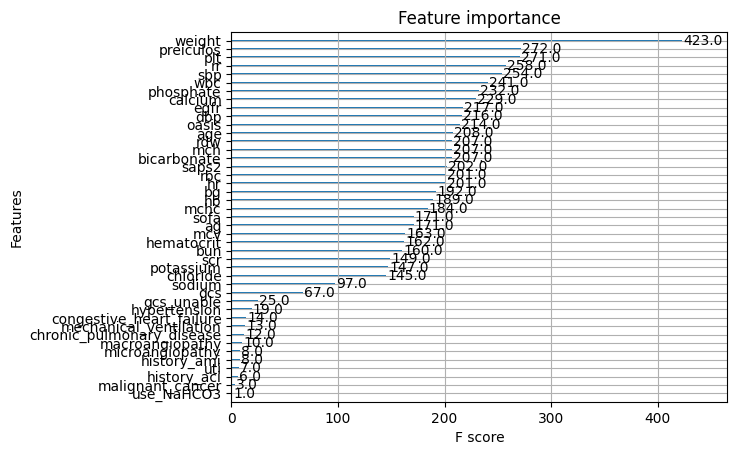

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

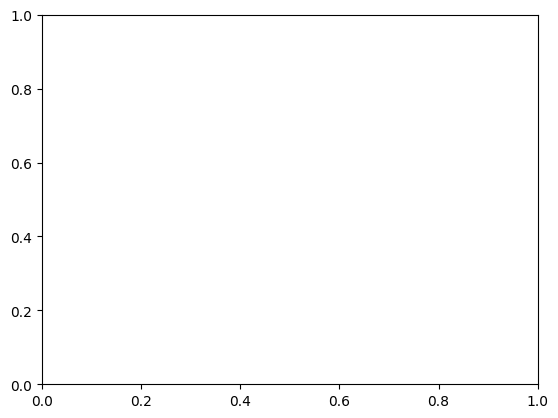

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))



[0]	validation_0-logloss:0.66688


[1]	validation_0-logloss:0.66396


[2]	validation_0-logloss:0.66176


[3]	validation_0-logloss:0.65957


[4]	validation_0-logloss:0.65739


[5]	validation_0-logloss:0.65530


[6]	validation_0-logloss:0.65270


[7]	validation_0-logloss:0.65033


[8]	validation_0-logloss:0.64834


[9]	validation_0-logloss:0.64631


[10]	validation_0-logloss:0.64405


[11]	validation_0-logloss:0.64219


[12]	validation_0-logloss:0.64093


[13]	validation_0-logloss:0.63923


[14]	validation_0-logloss:0.63724


[15]	validation_0-logloss:0.63516


[16]	validation_0-logloss:0.63286


[17]	validation_0-logloss:0.63068


[18]	validation_0-logloss:0.62959


[19]	validation_0-logloss:0.62755


[20]	validation_0-logloss:0.62539


[21]	validation_0-logloss:0.62370


[22]	validation_0-logloss:0.62202


[23]	validation_0-logloss:0.62107


[24]	validation_0-logloss:0.61919


[25]	validation_0-logloss:0.61655


[26]	validation_0-logloss:0.61536


[27]	validation_0-logloss:0.61366


[28]	validation_0-logloss:0.61220


[29]	validation_0-logloss:0.61026


[30]	validation_0-logloss:0.60900


[31]	validation_0-logloss:0.60786


[32]	validation_0-logloss:0.60665


[33]	validation_0-logloss:0.60597


[34]	validation_0-logloss:0.60412


[35]	validation_0-logloss:0.60252


[36]	validation_0-logloss:0.60101


[37]	validation_0-logloss:0.59966


[38]	validation_0-logloss:0.59819


[39]	validation_0-logloss:0.59712


[40]	validation_0-logloss:0.59580


[41]	validation_0-logloss:0.59508


[42]	validation_0-logloss:0.59337


[43]	validation_0-logloss:0.59184


[44]	validation_0-logloss:0.59018


[45]	validation_0-logloss:0.58884


[46]	validation_0-logloss:0.58783


[47]	validation_0-logloss:0.58642


[48]	validation_0-logloss:0.58542


[49]	validation_0-logloss:0.58459


[50]	validation_0-logloss:0.58320


[51]	validation_0-logloss:0.58214


[52]	validation_0-logloss:0.58150


[53]	validation_0-logloss:0.58045


[54]	validation_0-logloss:0.57949


[55]	validation_0-logloss:0.57844


[56]	validation_0-logloss:0.57725


[57]	validation_0-logloss:0.57622


[58]	validation_0-logloss:0.57517


[59]	validation_0-logloss:0.57429


[60]	validation_0-logloss:0.57319


[61]	validation_0-logloss:0.57204


[62]	validation_0-logloss:0.57094


[63]	validation_0-logloss:0.57059


[64]	validation_0-logloss:0.56942


[65]	validation_0-logloss:0.56825


[66]	validation_0-logloss:0.56694


[67]	validation_0-logloss:0.56650


[68]	validation_0-logloss:0.56550


[69]	validation_0-logloss:0.56448


[70]	validation_0-logloss:0.56335


[71]	validation_0-logloss:0.56241


[72]	validation_0-logloss:0.56164


[73]	validation_0-logloss:0.56094


[74]	validation_0-logloss:0.56007


[75]	validation_0-logloss:0.55933


[76]	validation_0-logloss:0.55892


[77]	validation_0-logloss:0.55758


[78]	validation_0-logloss:0.55673


[79]	validation_0-logloss:0.55568


[80]	validation_0-logloss:0.55462


[81]	validation_0-logloss:0.55406


[82]	validation_0-logloss:0.55338


[83]	validation_0-logloss:0.55252


[84]	validation_0-logloss:0.55203


[85]	validation_0-logloss:0.55176


[86]	validation_0-logloss:0.55143


[87]	validation_0-logloss:0.55109


[88]	validation_0-logloss:0.55049


[89]	validation_0-logloss:0.55004


[90]	validation_0-logloss:0.54909


[91]	validation_0-logloss:0.54843


[92]	validation_0-logloss:0.54778


[93]	validation_0-logloss:0.54731


[94]	validation_0-logloss:0.54656


[95]	validation_0-logloss:0.54563


[96]	validation_0-logloss:0.54507


[97]	validation_0-logloss:0.54486


[98]	validation_0-logloss:0.54416


[99]	validation_0-logloss:0.54345


[100]	validation_0-logloss:0.54334


[101]	validation_0-logloss:0.54368


[102]	validation_0-logloss:0.54284


[103]	validation_0-logloss:0.54220


[104]	validation_0-logloss:0.54171


[105]	validation_0-logloss:0.54121


[106]	validation_0-logloss:0.54050


[107]	validation_0-logloss:0.53997


[108]	validation_0-logloss:0.53990


[109]	validation_0-logloss:0.53936


[110]	validation_0-logloss:0.53884


[111]	validation_0-logloss:0.53848


[112]	validation_0-logloss:0.53798


[113]	validation_0-logloss:0.53726


[114]	validation_0-logloss:0.53628


[115]	validation_0-logloss:0.53563


[116]	validation_0-logloss:0.53553


[117]	validation_0-logloss:0.53578


[118]	validation_0-logloss:0.53546


[119]	validation_0-logloss:0.53474


[120]	validation_0-logloss:0.53437


[121]	validation_0-logloss:0.53420


[122]	validation_0-logloss:0.53412


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:11:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[123]	validation_0-logloss:0.53337


[124]	validation_0-logloss:0.53319


[125]	validation_0-logloss:0.53250


[126]	validation_0-logloss:0.53216


[127]	validation_0-logloss:0.53204


[128]	validation_0-logloss:0.53189


[129]	validation_0-logloss:0.53146


[130]	validation_0-logloss:0.53104


[131]	validation_0-logloss:0.53087


[132]	validation_0-logloss:0.53028


[133]	validation_0-logloss:0.52978


[134]	validation_0-logloss:0.52946


[135]	validation_0-logloss:0.52928


[136]	validation_0-logloss:0.52891


[137]	validation_0-logloss:0.52871


[138]	validation_0-logloss:0.52880


[139]	validation_0-logloss:0.52839


[140]	validation_0-logloss:0.52832


[141]	validation_0-logloss:0.52809


[142]	validation_0-logloss:0.52781


[143]	validation_0-logloss:0.52737


[144]	validation_0-logloss:0.52762


[145]	validation_0-logloss:0.52723


[146]	validation_0-logloss:0.52677


[147]	validation_0-logloss:0.52659


[148]	validation_0-logloss:0.52635


[149]	validation_0-logloss:0.52583


[150]	validation_0-logloss:0.52575


[151]	validation_0-logloss:0.52544


[152]	validation_0-logloss:0.52516


[153]	validation_0-logloss:0.52516


[154]	validation_0-logloss:0.52482


[155]	validation_0-logloss:0.52439


[156]	validation_0-logloss:0.52421


[157]	validation_0-logloss:0.52413


[158]	validation_0-logloss:0.52359


[159]	validation_0-logloss:0.52295


[160]	validation_0-logloss:0.52268


[161]	validation_0-logloss:0.52219


[162]	validation_0-logloss:0.52143


[163]	validation_0-logloss:0.52079


[164]	validation_0-logloss:0.52038


[165]	validation_0-logloss:0.52016


[166]	validation_0-logloss:0.52019


[167]	validation_0-logloss:0.52000


[168]	validation_0-logloss:0.51970


[169]	validation_0-logloss:0.51952


[170]	validation_0-logloss:0.51960


[171]	validation_0-logloss:0.51969


[172]	validation_0-logloss:0.51946


[173]	validation_0-logloss:0.51914


[174]	validation_0-logloss:0.51926


[175]	validation_0-logloss:0.51887


[176]	validation_0-logloss:0.51859


[177]	validation_0-logloss:0.51834


[178]	validation_0-logloss:0.51798


[179]	validation_0-logloss:0.51773


[180]	validation_0-logloss:0.51745


[181]	validation_0-logloss:0.51722


[182]	validation_0-logloss:0.51717


[183]	validation_0-logloss:0.51686


[184]	validation_0-logloss:0.51646


[185]	validation_0-logloss:0.51648


[186]	validation_0-logloss:0.51656


[187]	validation_0-logloss:0.51626


[188]	validation_0-logloss:0.51588


[189]	validation_0-logloss:0.51573


[190]	validation_0-logloss:0.51546


[191]	validation_0-logloss:0.51518


[192]	validation_0-logloss:0.51527


[193]	validation_0-logloss:0.51510


[194]	validation_0-logloss:0.51453


[195]	validation_0-logloss:0.51390


[196]	validation_0-logloss:0.51398


[197]	validation_0-logloss:0.51391


[198]	validation_0-logloss:0.51388


[199]	validation_0-logloss:0.51376


[200]	validation_0-logloss:0.51342


[201]	validation_0-logloss:0.51331


[202]	validation_0-logloss:0.51325


[203]	validation_0-logloss:0.51296


[204]	validation_0-logloss:0.51284


[205]	validation_0-logloss:0.51275


[206]	validation_0-logloss:0.51282


[207]	validation_0-logloss:0.51274


[208]	validation_0-logloss:0.51220


[209]	validation_0-logloss:0.51194


[210]	validation_0-logloss:0.51184

[211]	validation_0-logloss:0.51174


[212]	validation_0-logloss:0.51172


[213]	validation_0-logloss:0.51176


[214]	validation_0-logloss:0.51171


[215]	validation_0-logloss:0.51161


[216]	validation_0-logloss:0.51159


[217]	validation_0-logloss:0.51148


[218]	validation_0-logloss:0.51122


[219]	validation_0-logloss:0.51090


[220]	validation_0-logloss:0.51072


[221]	validation_0-logloss:0.51067


[222]	validation_0-logloss:0.51086


[223]	validation_0-logloss:0.51078


[224]	validation_0-logloss:0.51056


[225]	validation_0-logloss:0.51040


[226]	validation_0-logloss:0.51041


[227]	validation_0-logloss:0.51039


[228]	validation_0-logloss:0.51018


[229]	validation_0-logloss:0.50981


[230]	validation_0-logloss:0.50964


[231]	validation_0-logloss:0.50964


[232]	validation_0-logloss:0.50973


[233]	validation_0-logloss:0.50973


[234]	validation_0-logloss:0.50948


[235]	validation_0-logloss:0.50951


[236]	validation_0-logloss:0.50966


[237]	validation_0-logloss:0.50938


[238]	validation_0-logloss:0.50969


[239]	validation_0-logloss:0.50970


[240]	validation_0-logloss:0.50932


[241]	validation_0-logloss:0.50890


[242]	validation_0-logloss:0.50837


[243]	validation_0-logloss:0.50846


[244]	validation_0-logloss:0.50824


[245]	validation_0-logloss:0.50817


[246]	validation_0-logloss:0.50804


[247]	validation_0-logloss:0.50800


[248]	validation_0-logloss:0.50788


[249]	validation_0-logloss:0.50783


[250]	validation_0-logloss:0.50798


[251]	validation_0-logloss:0.50808


[252]	validation_0-logloss:0.50801


[253]	validation_0-logloss:0.50824


[254]	validation_0-logloss:0.50805


[255]	validation_0-logloss:0.50811


[256]	validation_0-logloss:0.50823


[257]	validation_0-logloss:0.50840


[258]	validation_0-logloss:0.50812


[0]	validation_0-logloss:0.66765


[1]	validation_0-logloss:0.66529


[2]	validation_0-logloss:0.66337


[3]	validation_0-logloss:0.66112


[4]	validation_0-logloss:0.65848


[5]	validation_0-logloss:0.65541


[6]	validation_0-logloss:0.65327


[7]	validation_0-logloss:0.65118


[8]	validation_0-logloss:0.64861


[9]	validation_0-logloss:0.64663


[10]	validation_0-logloss:0.64519


[11]	validation_0-logloss:0.64370


[12]	validation_0-logloss:0.64215


[13]	validation_0-logloss:0.64032


[14]	validation_0-logloss:0.63810


[15]	validation_0-logloss:0.63597


[16]	validation_0-logloss:0.63490


[17]	validation_0-logloss:0.63337


[18]	validation_0-logloss:0.63214


[19]	validation_0-logloss:0.63013


[20]	validation_0-logloss:0.62752


[21]	validation_0-logloss:0.62583


[22]	validation_0-logloss:0.62406


[23]	validation_0-logloss:0.62220


[24]	validation_0-logloss:0.62073


[25]	validation_0-logloss:0.61879


[26]	validation_0-logloss:0.61753


[27]	validation_0-logloss:0.61615


[28]	validation_0-logloss:0.61455


[29]	validation_0-logloss:0.61310


[30]	validation_0-logloss:0.61179


[31]	validation_0-logloss:0.61052


[32]	validation_0-logloss:0.60958


[33]	validation_0-logloss:0.60803


[34]	validation_0-logloss:0.60714


[35]	validation_0-logloss:0.60571


[36]	validation_0-logloss:0.60427


[37]	validation_0-logloss:0.60279


[38]	validation_0-logloss:0.60121


[39]	validation_0-logloss:0.59971


[40]	validation_0-logloss:0.59874


[41]	validation_0-logloss:0.59737


[42]	validation_0-logloss:0.59645


[43]	validation_0-logloss:0.59554


[44]	validation_0-logloss:0.59406


[45]	validation_0-logloss:0.59314


[46]	validation_0-logloss:0.59163


[47]	validation_0-logloss:0.59014


[48]	validation_0-logloss:0.58883


[49]	validation_0-logloss:0.58815


[50]	validation_0-logloss:0.58706


[51]	validation_0-logloss:0.58586


[52]	validation_0-logloss:0.58482


[53]	validation_0-logloss:0.58379


[54]	validation_0-logloss:0.58290


[55]	validation_0-logloss:0.58192


[56]	validation_0-logloss:0.58088


[57]	validation_0-logloss:0.57995


[58]	validation_0-logloss:0.57895


[59]	validation_0-logloss:0.57789


[60]	validation_0-logloss:0.57683


[61]	validation_0-logloss:0.57612


[62]	validation_0-logloss:0.57509


[63]	validation_0-logloss:0.57440


[64]	validation_0-logloss:0.57363


[65]	validation_0-logloss:0.57264


[66]	validation_0-logloss:0.57156


[67]	validation_0-logloss:0.57061


[68]	validation_0-logloss:0.56942


[69]	validation_0-logloss:0.56877


[70]	validation_0-logloss:0.56765


[71]	validation_0-logloss:0.56676


[72]	validation_0-logloss:0.56549


[73]	validation_0-logloss:0.56444


[74]	validation_0-logloss:0.56360


[75]	validation_0-logloss:0.56268


[76]	validation_0-logloss:0.56232


[77]	validation_0-logloss:0.56165


[78]	validation_0-logloss:0.56097


[79]	validation_0-logloss:0.56004


[80]	validation_0-logloss:0.55955


[81]	validation_0-logloss:0.55922


[82]	validation_0-logloss:0.55833


[83]	validation_0-logloss:0.55716


[84]	validation_0-logloss:0.55638


[85]	validation_0-logloss:0.55594


[86]	validation_0-logloss:0.55518


[87]	validation_0-logloss:0.55463


[88]	validation_0-logloss:0.55399


[89]	validation_0-logloss:0.55359


[90]	validation_0-logloss:0.55281


[91]	validation_0-logloss:0.55215


[92]	validation_0-logloss:0.55167


[93]	validation_0-logloss:0.55107


[94]	validation_0-logloss:0.55067


[95]	validation_0-logloss:0.55034


[96]	validation_0-logloss:0.54971


[97]	validation_0-logloss:0.54951


[98]	validation_0-logloss:0.54875


[99]	validation_0-logloss:0.54786


[100]	validation_0-logloss:0.54710


[101]	validation_0-logloss:0.54654


[102]	validation_0-logloss:0.54628


[103]	validation_0-logloss:0.54568


[104]	validation_0-logloss:0.54553


[105]	validation_0-logloss:0.54500


[106]	validation_0-logloss:0.54456


[107]	validation_0-logloss:0.54405


[108]	validation_0-logloss:0.54356


[109]	validation_0-logloss:0.54270


[110]	validation_0-logloss:0.54239


[111]	validation_0-logloss:0.54164


[112]	validation_0-logloss:0.54106


[113]	validation_0-logloss:0.54061


[114]	validation_0-logloss:0.54021


[115]	validation_0-logloss:0.53934


[116]	validation_0-logloss:0.53886


[117]	validation_0-logloss:0.53822


[118]	validation_0-logloss:0.53762


[119]	validation_0-logloss:0.53734


[120]	validation_0-logloss:0.53683


[121]	validation_0-logloss:0.53637


[122]	validation_0-logloss:0.53577


[123]	validation_0-logloss:0.53535


[124]	validation_0-logloss:0.53490


[125]	validation_0-logloss:0.53442


[126]	validation_0-logloss:0.53339


[127]	validation_0-logloss:0.53281


[128]	validation_0-logloss:0.53288


[129]	validation_0-logloss:0.53221


[130]	validation_0-logloss:0.53195


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:11:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[131]	validation_0-logloss:0.53166


[132]	validation_0-logloss:0.53159


[133]	validation_0-logloss:0.53117


[134]	validation_0-logloss:0.53076


[135]	validation_0-logloss:0.53044


[136]	validation_0-logloss:0.52968


[137]	validation_0-logloss:0.52946


[138]	validation_0-logloss:0.52939


[139]	validation_0-logloss:0.52915


[140]	validation_0-logloss:0.52896


[141]	validation_0-logloss:0.52875


[142]	validation_0-logloss:0.52844


[143]	validation_0-logloss:0.52792


[144]	validation_0-logloss:0.52762


[145]	validation_0-logloss:0.52701


[146]	validation_0-logloss:0.52662


[147]	validation_0-logloss:0.52653


[148]	validation_0-logloss:0.52590


[149]	validation_0-logloss:0.52598


[150]	validation_0-logloss:0.52557


[151]	validation_0-logloss:0.52545


[152]	validation_0-logloss:0.52501


[153]	validation_0-logloss:0.52479


[154]	validation_0-logloss:0.52466


[155]	validation_0-logloss:0.52436


[156]	validation_0-logloss:0.52413

[157]	validation_0-logloss:0.52347


[158]	validation_0-logloss:0.52318


[159]	validation_0-logloss:0.52271


[160]	validation_0-logloss:0.52262


[161]	validation_0-logloss:0.52239


[162]	validation_0-logloss:0.52219


[163]	validation_0-logloss:0.52203


[164]	validation_0-logloss:0.52199


[165]	validation_0-logloss:0.52188


[166]	validation_0-logloss:0.52159


[167]	validation_0-logloss:0.52119


[168]	validation_0-logloss:0.52070


[169]	validation_0-logloss:0.52050


[170]	validation_0-logloss:0.52048


[171]	validation_0-logloss:0.52040


[172]	validation_0-logloss:0.51970


[173]	validation_0-logloss:0.51937


[174]	validation_0-logloss:0.51886


[175]	validation_0-logloss:0.51856


[176]	validation_0-logloss:0.51858


[177]	validation_0-logloss:0.51862


[178]	validation_0-logloss:0.51853


[179]	validation_0-logloss:0.51850


[180]	validation_0-logloss:0.51857


[181]	validation_0-logloss:0.51857


[182]	validation_0-logloss:0.51877


[183]	validation_0-logloss:0.51862


[184]	validation_0-logloss:0.51827


[185]	validation_0-logloss:0.51831


[186]	validation_0-logloss:0.51811


[187]	validation_0-logloss:0.51799


[188]	validation_0-logloss:0.51776


[189]	validation_0-logloss:0.51762


[190]	validation_0-logloss:0.51753


[191]	validation_0-logloss:0.51776


[192]	validation_0-logloss:0.51751


[193]	validation_0-logloss:0.51731


[194]	validation_0-logloss:0.51709


[195]	validation_0-logloss:0.51710


[196]	validation_0-logloss:0.51740


[197]	validation_0-logloss:0.51701


[198]	validation_0-logloss:0.51663


[199]	validation_0-logloss:0.51644


[200]	validation_0-logloss:0.51678

[201]	validation_0-logloss:0.51675


[202]	validation_0-logloss:0.51666


[203]	validation_0-logloss:0.51663


[204]	validation_0-logloss:0.51626


[205]	validation_0-logloss:0.51607

[206]	validation_0-logloss:0.51595


[207]	validation_0-logloss:0.51547


[208]	validation_0-logloss:0.51575


[209]	validation_0-logloss:0.51567


[210]	validation_0-logloss:0.51513


[211]	validation_0-logloss:0.51466


[212]	validation_0-logloss:0.51398


[213]	validation_0-logloss:0.51395


[214]	validation_0-logloss:0.51375


[215]	validation_0-logloss:0.51374


[216]	validation_0-logloss:0.51336


[217]	validation_0-logloss:0.51315


[218]	validation_0-logloss:0.51281


[219]	validation_0-logloss:0.51262


[220]	validation_0-logloss:0.51257


[221]	validation_0-logloss:0.51220


[222]	validation_0-logloss:0.51214


[223]	validation_0-logloss:0.51179


[224]	validation_0-logloss:0.51128


[225]	validation_0-logloss:0.51132


[226]	validation_0-logloss:0.51150


[227]	validation_0-logloss:0.51158

[228]	validation_0-logloss:0.51147


[229]	validation_0-logloss:0.51155


[230]	validation_0-logloss:0.51160


[231]	validation_0-logloss:0.51172


[232]	validation_0-logloss:0.51153


[233]	validation_0-logloss:0.51127


[234]	validation_0-logloss:0.51135


[235]	validation_0-logloss:0.51114


[236]	validation_0-logloss:0.51099


[237]	validation_0-logloss:0.51098


[238]	validation_0-logloss:0.51104


[239]	validation_0-logloss:0.51102


[240]	validation_0-logloss:0.51075


[241]	validation_0-logloss:0.51084


[242]	validation_0-logloss:0.51107


[243]	validation_0-logloss:0.51082


[244]	validation_0-logloss:0.51074


[245]	validation_0-logloss:0.51075


[246]	validation_0-logloss:0.51049


[247]	validation_0-logloss:0.51024

[248]	validation_0-logloss:0.51030


[249]	validation_0-logloss:0.51009


[250]	validation_0-logloss:0.50976


[251]	validation_0-logloss:0.50964


[252]	validation_0-logloss:0.50979


[253]	validation_0-logloss:0.50987


[254]	validation_0-logloss:0.50971


[255]	validation_0-logloss:0.50992


[256]	validation_0-logloss:0.51002


[257]	validation_0-logloss:0.51023


[258]	validation_0-logloss:0.50995


[259]	validation_0-logloss:0.51013


[260]	validation_0-logloss:0.51000


[261]	validation_0-logloss:0.51015


[0]	validation_0-logloss:0.66793


[1]	validation_0-logloss:0.66551


[2]	validation_0-logloss:0.66364


[3]	validation_0-logloss:0.66191


[4]	validation_0-logloss:0.66043


[5]	validation_0-logloss:0.65920


[6]	validation_0-logloss:0.65792


[7]	validation_0-logloss:0.65662


[8]	validation_0-logloss:0.65459


[9]	validation_0-logloss:0.65360


[10]	validation_0-logloss:0.65191


[11]	validation_0-logloss:0.64978


[12]	validation_0-logloss:0.64787


[13]	validation_0-logloss:0.64661


[14]	validation_0-logloss:0.64466


[15]	validation_0-logloss:0.64322


[16]	validation_0-logloss:0.64158


[17]	validation_0-logloss:0.63953


[18]	validation_0-logloss:0.63802


[19]	validation_0-logloss:0.63664


[20]	validation_0-logloss:0.63542


[21]	validation_0-logloss:0.63439


[22]	validation_0-logloss:0.63301


[23]	validation_0-logloss:0.63155


[24]	validation_0-logloss:0.63061


[25]	validation_0-logloss:0.62952


[26]	validation_0-logloss:0.62829


[27]	validation_0-logloss:0.62720


[28]	validation_0-logloss:0.62632


[29]	validation_0-logloss:0.62539


[30]	validation_0-logloss:0.62409


[31]	validation_0-logloss:0.62303


[32]	validation_0-logloss:0.62192


[33]	validation_0-logloss:0.62092


[34]	validation_0-logloss:0.62007


[35]	validation_0-logloss:0.61834


[36]	validation_0-logloss:0.61714


[37]	validation_0-logloss:0.61655


[38]	validation_0-logloss:0.61602


[39]	validation_0-logloss:0.61522


[40]	validation_0-logloss:0.61448


[41]	validation_0-logloss:0.61365


[42]	validation_0-logloss:0.61273


[43]	validation_0-logloss:0.61120


[44]	validation_0-logloss:0.60989


[45]	validation_0-logloss:0.60889


[46]	validation_0-logloss:0.60840


[47]	validation_0-logloss:0.60719


[48]	validation_0-logloss:0.60661


[49]	validation_0-logloss:0.60555


[50]	validation_0-logloss:0.60471


[51]	validation_0-logloss:0.60409


[52]	validation_0-logloss:0.60326


[53]	validation_0-logloss:0.60246


[54]	validation_0-logloss:0.60183


[55]	validation_0-logloss:0.60086


[56]	validation_0-logloss:0.59965


[57]	validation_0-logloss:0.59934


[58]	validation_0-logloss:0.59817


[59]	validation_0-logloss:0.59757


[60]	validation_0-logloss:0.59716


[61]	validation_0-logloss:0.59609


[62]	validation_0-logloss:0.59519


[63]	validation_0-logloss:0.59406


[64]	validation_0-logloss:0.59313


[65]	validation_0-logloss:0.59275


[66]	validation_0-logloss:0.59176


[67]	validation_0-logloss:0.59044


[68]	validation_0-logloss:0.58972


[69]	validation_0-logloss:0.58857


[70]	validation_0-logloss:0.58789


[71]	validation_0-logloss:0.58725


[72]	validation_0-logloss:0.58587


[73]	validation_0-logloss:0.58521


[74]	validation_0-logloss:0.58481


[75]	validation_0-logloss:0.58435


[76]	validation_0-logloss:0.58373


[77]	validation_0-logloss:0.58357


[78]	validation_0-logloss:0.58272


[79]	validation_0-logloss:0.58250


[80]	validation_0-logloss:0.58232


[81]	validation_0-logloss:0.58183


[82]	validation_0-logloss:0.58116


[83]	validation_0-logloss:0.58060


[84]	validation_0-logloss:0.57971


[85]	validation_0-logloss:0.57962


[86]	validation_0-logloss:0.57940


[87]	validation_0-logloss:0.57917


[88]	validation_0-logloss:0.57867


[89]	validation_0-logloss:0.57869


[90]	validation_0-logloss:0.57826


[91]	validation_0-logloss:0.57819


[92]	validation_0-logloss:0.57758


[93]	validation_0-logloss:0.57727


[94]	validation_0-logloss:0.57688


[95]	validation_0-logloss:0.57674


[96]	validation_0-logloss:0.57689


[97]	validation_0-logloss:0.57644


[98]	validation_0-logloss:0.57601


[99]	validation_0-logloss:0.57582


[100]	validation_0-logloss:0.57571


[101]	validation_0-logloss:0.57565


[102]	validation_0-logloss:0.57519


[103]	validation_0-logloss:0.57460


[104]	validation_0-logloss:0.57390


[105]	validation_0-logloss:0.57362


[106]	validation_0-logloss:0.57316


[107]	validation_0-logloss:0.57262


[108]	validation_0-logloss:0.57220


[109]	validation_0-logloss:0.57221


[110]	validation_0-logloss:0.57194


[111]	validation_0-logloss:0.57176


[112]	validation_0-logloss:0.57133


[113]	validation_0-logloss:0.57130


[114]	validation_0-logloss:0.57066


[115]	validation_0-logloss:0.57059


[116]	validation_0-logloss:0.57021


[117]	validation_0-logloss:0.56988


[118]	validation_0-logloss:0.56940


[119]	validation_0-logloss:0.56886


[120]	validation_0-logloss:0.56822


[121]	validation_0-logloss:0.56792


[122]	validation_0-logloss:0.56757


[123]	validation_0-logloss:0.56708


[124]	validation_0-logloss:0.56638


[125]	validation_0-logloss:0.56590


[126]	validation_0-logloss:0.56601


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:11:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[127]	validation_0-logloss:0.56612


[128]	validation_0-logloss:0.56569


[129]	validation_0-logloss:0.56538


[130]	validation_0-logloss:0.56549


[131]	validation_0-logloss:0.56510


[132]	validation_0-logloss:0.56523


[133]	validation_0-logloss:0.56472


[134]	validation_0-logloss:0.56457


[135]	validation_0-logloss:0.56384


[136]	validation_0-logloss:0.56374


[137]	validation_0-logloss:0.56315


[138]	validation_0-logloss:0.56276


[139]	validation_0-logloss:0.56253


[140]	validation_0-logloss:0.56200


[141]	validation_0-logloss:0.56208


[142]	validation_0-logloss:0.56200


[143]	validation_0-logloss:0.56170


[144]	validation_0-logloss:0.56154


[145]	validation_0-logloss:0.56124


[146]	validation_0-logloss:0.56097


[147]	validation_0-logloss:0.56087


[148]	validation_0-logloss:0.56039


[149]	validation_0-logloss:0.56021


[150]	validation_0-logloss:0.55997


[151]	validation_0-logloss:0.55987


[152]	validation_0-logloss:0.55960


[153]	validation_0-logloss:0.55978

[154]	validation_0-logloss:0.55964


[155]	validation_0-logloss:0.55965


[156]	validation_0-logloss:0.55923


[157]	validation_0-logloss:0.55916


[158]	validation_0-logloss:0.55897


[159]	validation_0-logloss:0.55873


[160]	validation_0-logloss:0.55871


[161]	validation_0-logloss:0.55835


[162]	validation_0-logloss:0.55829


[163]	validation_0-logloss:0.55847


[164]	validation_0-logloss:0.55855


[165]	validation_0-logloss:0.55831


[166]	validation_0-logloss:0.55838


[167]	validation_0-logloss:0.55774


[168]	validation_0-logloss:0.55786


[169]	validation_0-logloss:0.55786


[170]	validation_0-logloss:0.55777


[171]	validation_0-logloss:0.55768


[172]	validation_0-logloss:0.55750


[173]	validation_0-logloss:0.55720


[174]	validation_0-logloss:0.55727


[175]	validation_0-logloss:0.55665


[176]	validation_0-logloss:0.55645


[177]	validation_0-logloss:0.55605


[178]	validation_0-logloss:0.55585


[179]	validation_0-logloss:0.55591


[180]	validation_0-logloss:0.55608


[181]	validation_0-logloss:0.55588


[182]	validation_0-logloss:0.55579


[183]	validation_0-logloss:0.55555


[184]	validation_0-logloss:0.55553


[185]	validation_0-logloss:0.55539


[186]	validation_0-logloss:0.55557


[187]	validation_0-logloss:0.55528


[188]	validation_0-logloss:0.55533


[189]	validation_0-logloss:0.55532


[190]	validation_0-logloss:0.55526


[191]	validation_0-logloss:0.55526


[192]	validation_0-logloss:0.55475


[193]	validation_0-logloss:0.55458


[194]	validation_0-logloss:0.55430


[195]	validation_0-logloss:0.55434


[196]	validation_0-logloss:0.55414


[197]	validation_0-logloss:0.55388


[198]	validation_0-logloss:0.55400


[199]	validation_0-logloss:0.55398


[200]	validation_0-logloss:0.55370


[201]	validation_0-logloss:0.55394


[202]	validation_0-logloss:0.55376


[203]	validation_0-logloss:0.55381


[204]	validation_0-logloss:0.55404


[205]	validation_0-logloss:0.55418


[206]	validation_0-logloss:0.55411


[207]	validation_0-logloss:0.55391


[208]	validation_0-logloss:0.55394


[209]	validation_0-logloss:0.55361


[210]	validation_0-logloss:0.55361


[211]	validation_0-logloss:0.55344


[212]	validation_0-logloss:0.55335


[213]	validation_0-logloss:0.55321


[214]	validation_0-logloss:0.55336


[215]	validation_0-logloss:0.55341


[216]	validation_0-logloss:0.55351


[217]	validation_0-logloss:0.55377


[218]	validation_0-logloss:0.55393


[219]	validation_0-logloss:0.55372


[220]	validation_0-logloss:0.55389


[221]	validation_0-logloss:0.55385


[222]	validation_0-logloss:0.55357


[0]	validation_0-logloss:0.66774


[1]	validation_0-logloss:0.66544


[2]	validation_0-logloss:0.66263


[3]	validation_0-logloss:0.66100


[4]	validation_0-logloss:0.65864


[5]	validation_0-logloss:0.65656


[6]	validation_0-logloss:0.65478


[7]	validation_0-logloss:0.65342


[8]	validation_0-logloss:0.65148


[9]	validation_0-logloss:0.65001


[10]	validation_0-logloss:0.64943


[11]	validation_0-logloss:0.64759


[12]	validation_0-logloss:0.64541


[13]	validation_0-logloss:0.64358


[14]	validation_0-logloss:0.64151


[15]	validation_0-logloss:0.64013


[16]	validation_0-logloss:0.63797


[17]	validation_0-logloss:0.63627


[18]	validation_0-logloss:0.63520


[19]	validation_0-logloss:0.63421


[20]	validation_0-logloss:0.63243


[21]	validation_0-logloss:0.63136


[22]	validation_0-logloss:0.62985


[23]	validation_0-logloss:0.62838


[24]	validation_0-logloss:0.62691


[25]	validation_0-logloss:0.62492


[26]	validation_0-logloss:0.62382


[27]	validation_0-logloss:0.62201


[28]	validation_0-logloss:0.62063


[29]	validation_0-logloss:0.61966


[30]	validation_0-logloss:0.61863


[31]	validation_0-logloss:0.61746


[32]	validation_0-logloss:0.61648


[33]	validation_0-logloss:0.61462


[34]	validation_0-logloss:0.61291


[35]	validation_0-logloss:0.61186


[36]	validation_0-logloss:0.61042


[37]	validation_0-logloss:0.60974


[38]	validation_0-logloss:0.60862


[39]	validation_0-logloss:0.60754


[40]	validation_0-logloss:0.60669


[41]	validation_0-logloss:0.60585


[42]	validation_0-logloss:0.60486


[43]	validation_0-logloss:0.60396


[44]	validation_0-logloss:0.60294


[45]	validation_0-logloss:0.60193


[46]	validation_0-logloss:0.60092


[47]	validation_0-logloss:0.59908


[48]	validation_0-logloss:0.59805


[49]	validation_0-logloss:0.59687


[50]	validation_0-logloss:0.59603


[51]	validation_0-logloss:0.59510


[52]	validation_0-logloss:0.59393


[53]	validation_0-logloss:0.59269


[54]	validation_0-logloss:0.59162


[55]	validation_0-logloss:0.59055


[56]	validation_0-logloss:0.59001


[57]	validation_0-logloss:0.58858


[58]	validation_0-logloss:0.58738


[59]	validation_0-logloss:0.58734


[60]	validation_0-logloss:0.58644


[61]	validation_0-logloss:0.58517


[62]	validation_0-logloss:0.58422


[63]	validation_0-logloss:0.58343


[64]	validation_0-logloss:0.58265


[65]	validation_0-logloss:0.58182


[66]	validation_0-logloss:0.58112


[67]	validation_0-logloss:0.58057


[68]	validation_0-logloss:0.57958


[69]	validation_0-logloss:0.57893


[70]	validation_0-logloss:0.57798


[71]	validation_0-logloss:0.57714


[72]	validation_0-logloss:0.57631


[73]	validation_0-logloss:0.57545


[74]	validation_0-logloss:0.57474


[75]	validation_0-logloss:0.57399


[76]	validation_0-logloss:0.57363


[77]	validation_0-logloss:0.57273


[78]	validation_0-logloss:0.57173


[79]	validation_0-logloss:0.57117


[80]	validation_0-logloss:0.57041


[81]	validation_0-logloss:0.57014


[82]	validation_0-logloss:0.56962


[83]	validation_0-logloss:0.56900


[84]	validation_0-logloss:0.56856


[85]	validation_0-logloss:0.56786


[86]	validation_0-logloss:0.56743


[87]	validation_0-logloss:0.56704


[88]	validation_0-logloss:0.56628


[89]	validation_0-logloss:0.56612


[90]	validation_0-logloss:0.56575


[91]	validation_0-logloss:0.56538


[92]	validation_0-logloss:0.56478


[93]	validation_0-logloss:0.56410


[94]	validation_0-logloss:0.56399


[95]	validation_0-logloss:0.56333


[96]	validation_0-logloss:0.56283


[97]	validation_0-logloss:0.56233


[98]	validation_0-logloss:0.56195


[99]	validation_0-logloss:0.56117


[100]	validation_0-logloss:0.56071


[101]	validation_0-logloss:0.56010


[102]	validation_0-logloss:0.55994


[103]	validation_0-logloss:0.55991


[104]	validation_0-logloss:0.55923


[105]	validation_0-logloss:0.55918


[106]	validation_0-logloss:0.55862


[107]	validation_0-logloss:0.55801


[108]	validation_0-logloss:0.55753


[109]	validation_0-logloss:0.55685


[110]	validation_0-logloss:0.55640


[111]	validation_0-logloss:0.55588


[112]	validation_0-logloss:0.55560


[113]	validation_0-logloss:0.55525


[114]	validation_0-logloss:0.55477


[115]	validation_0-logloss:0.55430


[116]	validation_0-logloss:0.55387


[117]	validation_0-logloss:0.55380


[118]	validation_0-logloss:0.55347


[119]	validation_0-logloss:0.55286


[120]	validation_0-logloss:0.55233


[121]	validation_0-logloss:0.55184


[122]	validation_0-logloss:0.55134


[123]	validation_0-logloss:0.55105


[124]	validation_0-logloss:0.55044


[125]	validation_0-logloss:0.55066


[126]	validation_0-logloss:0.55013


[127]	validation_0-logloss:0.55008


[128]	validation_0-logloss:0.54958


[129]	validation_0-logloss:0.54908


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:11:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[130]	validation_0-logloss:0.54865


[131]	validation_0-logloss:0.54823


[132]	validation_0-logloss:0.54788


[133]	validation_0-logloss:0.54788


[134]	validation_0-logloss:0.54773


[135]	validation_0-logloss:0.54764


[136]	validation_0-logloss:0.54733


[137]	validation_0-logloss:0.54735


[138]	validation_0-logloss:0.54727


[139]	validation_0-logloss:0.54714


[140]	validation_0-logloss:0.54681


[141]	validation_0-logloss:0.54614


[142]	validation_0-logloss:0.54593


[143]	validation_0-logloss:0.54541


[144]	validation_0-logloss:0.54533


[145]	validation_0-logloss:0.54503


[146]	validation_0-logloss:0.54456


[147]	validation_0-logloss:0.54405


[148]	validation_0-logloss:0.54403


[149]	validation_0-logloss:0.54400


[150]	validation_0-logloss:0.54365

[151]	validation_0-logloss:0.54355


[152]	validation_0-logloss:0.54338


[153]	validation_0-logloss:0.54314


[154]	validation_0-logloss:0.54279


[155]	validation_0-logloss:0.54256


[156]	validation_0-logloss:0.54204


[157]	validation_0-logloss:0.54173


[158]	validation_0-logloss:0.54097


[159]	validation_0-logloss:0.54047


[160]	validation_0-logloss:0.54038


[161]	validation_0-logloss:0.54008


[162]	validation_0-logloss:0.54030


[163]	validation_0-logloss:0.53985


[164]	validation_0-logloss:0.53948


[165]	validation_0-logloss:0.53937


[166]	validation_0-logloss:0.53894


[167]	validation_0-logloss:0.53874


[168]	validation_0-logloss:0.53881


[169]	validation_0-logloss:0.53865


[170]	validation_0-logloss:0.53865


[171]	validation_0-logloss:0.53874


[172]	validation_0-logloss:0.53904


[173]	validation_0-logloss:0.53890


[174]	validation_0-logloss:0.53846


[175]	validation_0-logloss:0.53819


[176]	validation_0-logloss:0.53782


[177]	validation_0-logloss:0.53758


[178]	validation_0-logloss:0.53730


[179]	validation_0-logloss:0.53721


[180]	validation_0-logloss:0.53739


[181]	validation_0-logloss:0.53735


[182]	validation_0-logloss:0.53714


[183]	validation_0-logloss:0.53711


[184]	validation_0-logloss:0.53682


[185]	validation_0-logloss:0.53663


[186]	validation_0-logloss:0.53645


[187]	validation_0-logloss:0.53612


[188]	validation_0-logloss:0.53594


[189]	validation_0-logloss:0.53540


[190]	validation_0-logloss:0.53507


[191]	validation_0-logloss:0.53470


[192]	validation_0-logloss:0.53442


[193]	validation_0-logloss:0.53425


[194]	validation_0-logloss:0.53390


[195]	validation_0-logloss:0.53359


[196]	validation_0-logloss:0.53380


[197]	validation_0-logloss:0.53389


[198]	validation_0-logloss:0.53383


[199]	validation_0-logloss:0.53366


[200]	validation_0-logloss:0.53366


[201]	validation_0-logloss:0.53371


[202]	validation_0-logloss:0.53334


[203]	validation_0-logloss:0.53317


[204]	validation_0-logloss:0.53325


[205]	validation_0-logloss:0.53330


[206]	validation_0-logloss:0.53334


[207]	validation_0-logloss:0.53344

[208]	validation_0-logloss:0.53295


[209]	validation_0-logloss:0.53238


[210]	validation_0-logloss:0.53199


[211]	validation_0-logloss:0.53179


[212]	validation_0-logloss:0.53153


[213]	validation_0-logloss:0.53167


[214]	validation_0-logloss:0.53193


[215]	validation_0-logloss:0.53190


[216]	validation_0-logloss:0.53227


[217]	validation_0-logloss:0.53223


[218]	validation_0-logloss:0.53220


[219]	validation_0-logloss:0.53224


[220]	validation_0-logloss:0.53232


[221]	validation_0-logloss:0.53202


[222]	validation_0-logloss:0.53219


[0]	validation_0-logloss:0.66819


[1]	validation_0-logloss:0.66544


[2]	validation_0-logloss:0.66353


[3]	validation_0-logloss:0.66122


[4]	validation_0-logloss:0.65993


[5]	validation_0-logloss:0.65801


[6]	validation_0-logloss:0.65646


[7]	validation_0-logloss:0.65453


[8]	validation_0-logloss:0.65228


[9]	validation_0-logloss:0.65055


[10]	validation_0-logloss:0.64857


[11]	validation_0-logloss:0.64697


[12]	validation_0-logloss:0.64495


[13]	validation_0-logloss:0.64279


[14]	validation_0-logloss:0.64093


[15]	validation_0-logloss:0.63969


[16]	validation_0-logloss:0.63784


[17]	validation_0-logloss:0.63645


[18]	validation_0-logloss:0.63518


[19]	validation_0-logloss:0.63370


[20]	validation_0-logloss:0.63219


[21]	validation_0-logloss:0.63100


[22]	validation_0-logloss:0.62919


[23]	validation_0-logloss:0.62737


[24]	validation_0-logloss:0.62565


[25]	validation_0-logloss:0.62408


[26]	validation_0-logloss:0.62321


[27]	validation_0-logloss:0.62171


[28]	validation_0-logloss:0.62023


[29]	validation_0-logloss:0.61881


[30]	validation_0-logloss:0.61756


[31]	validation_0-logloss:0.61573


[32]	validation_0-logloss:0.61455


[33]	validation_0-logloss:0.61301


[34]	validation_0-logloss:0.61138


[35]	validation_0-logloss:0.61031


[36]	validation_0-logloss:0.60878


[37]	validation_0-logloss:0.60825


[38]	validation_0-logloss:0.60732


[39]	validation_0-logloss:0.60570


[40]	validation_0-logloss:0.60436


[41]	validation_0-logloss:0.60371


[42]	validation_0-logloss:0.60234


[43]	validation_0-logloss:0.60108


[44]	validation_0-logloss:0.59980


[45]	validation_0-logloss:0.59900


[46]	validation_0-logloss:0.59794


[47]	validation_0-logloss:0.59704


[48]	validation_0-logloss:0.59620


[49]	validation_0-logloss:0.59480


[50]	validation_0-logloss:0.59396


[51]	validation_0-logloss:0.59307


[52]	validation_0-logloss:0.59205


[53]	validation_0-logloss:0.59117


[54]	validation_0-logloss:0.59033


[55]	validation_0-logloss:0.58967


[56]	validation_0-logloss:0.58877


[57]	validation_0-logloss:0.58750


[58]	validation_0-logloss:0.58672


[59]	validation_0-logloss:0.58583


[60]	validation_0-logloss:0.58484


[61]	validation_0-logloss:0.58400


[62]	validation_0-logloss:0.58321


[63]	validation_0-logloss:0.58183


[64]	validation_0-logloss:0.58124


[65]	validation_0-logloss:0.58050


[66]	validation_0-logloss:0.57933


[67]	validation_0-logloss:0.57849


[68]	validation_0-logloss:0.57799


[69]	validation_0-logloss:0.57745


[70]	validation_0-logloss:0.57655


[71]	validation_0-logloss:0.57604


[72]	validation_0-logloss:0.57537


[73]	validation_0-logloss:0.57472


[74]	validation_0-logloss:0.57407


[75]	validation_0-logloss:0.57341


[76]	validation_0-logloss:0.57307


[77]	validation_0-logloss:0.57272


[78]	validation_0-logloss:0.57224


[79]	validation_0-logloss:0.57147


[80]	validation_0-logloss:0.57096


[81]	validation_0-logloss:0.57071


[82]	validation_0-logloss:0.57009


[83]	validation_0-logloss:0.56979


[84]	validation_0-logloss:0.56928


[85]	validation_0-logloss:0.56873


[86]	validation_0-logloss:0.56805


[87]	validation_0-logloss:0.56754


[88]	validation_0-logloss:0.56705


[89]	validation_0-logloss:0.56659


[90]	validation_0-logloss:0.56670


[91]	validation_0-logloss:0.56602


[92]	validation_0-logloss:0.56567


[93]	validation_0-logloss:0.56502


[94]	validation_0-logloss:0.56502


[95]	validation_0-logloss:0.56449


[96]	validation_0-logloss:0.56400


[97]	validation_0-logloss:0.56286


[98]	validation_0-logloss:0.56202


[99]	validation_0-logloss:0.56161


[100]	validation_0-logloss:0.56114


[101]	validation_0-logloss:0.56030


[102]	validation_0-logloss:0.56041


[103]	validation_0-logloss:0.55976


[104]	validation_0-logloss:0.55913


[105]	validation_0-logloss:0.55882


[106]	validation_0-logloss:0.55837


[107]	validation_0-logloss:0.55832


[108]	validation_0-logloss:0.55787


[109]	validation_0-logloss:0.55736


[110]	validation_0-logloss:0.55659


[111]	validation_0-logloss:0.55638


[112]	validation_0-logloss:0.55584


[113]	validation_0-logloss:0.55538


[114]	validation_0-logloss:0.55465


[115]	validation_0-logloss:0.55441


[116]	validation_0-logloss:0.55385


[117]	validation_0-logloss:0.55344


[118]	validation_0-logloss:0.55305


[119]	validation_0-logloss:0.55266


[120]	validation_0-logloss:0.55223


[121]	validation_0-logloss:0.55216


[122]	validation_0-logloss:0.55223


[123]	validation_0-logloss:0.55183


[124]	validation_0-logloss:0.55151


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:11:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[125]	validation_0-logloss:0.55162


[126]	validation_0-logloss:0.55109


[127]	validation_0-logloss:0.55056


[128]	validation_0-logloss:0.55025


[129]	validation_0-logloss:0.54997


[130]	validation_0-logloss:0.54986


[131]	validation_0-logloss:0.54948


[132]	validation_0-logloss:0.54897


[133]	validation_0-logloss:0.54918


[134]	validation_0-logloss:0.54886


[135]	validation_0-logloss:0.54891


[136]	validation_0-logloss:0.54875


[137]	validation_0-logloss:0.54825


[138]	validation_0-logloss:0.54797


[139]	validation_0-logloss:0.54769


[140]	validation_0-logloss:0.54736


[141]	validation_0-logloss:0.54734


[142]	validation_0-logloss:0.54722


[143]	validation_0-logloss:0.54746


[144]	validation_0-logloss:0.54722


[145]	validation_0-logloss:0.54691


[146]	validation_0-logloss:0.54642


[147]	validation_0-logloss:0.54660


[148]	validation_0-logloss:0.54635


[149]	validation_0-logloss:0.54596


[150]	validation_0-logloss:0.54547


[151]	validation_0-logloss:0.54550


[152]	validation_0-logloss:0.54506


[153]	validation_0-logloss:0.54486


[154]	validation_0-logloss:0.54422


[155]	validation_0-logloss:0.54420


[156]	validation_0-logloss:0.54394


[157]	validation_0-logloss:0.54389


[158]	validation_0-logloss:0.54368


[159]	validation_0-logloss:0.54337


[160]	validation_0-logloss:0.54284


[161]	validation_0-logloss:0.54228


[162]	validation_0-logloss:0.54211


[163]	validation_0-logloss:0.54234


[164]	validation_0-logloss:0.54236


[165]	validation_0-logloss:0.54209


[166]	validation_0-logloss:0.54215


[167]	validation_0-logloss:0.54208


[168]	validation_0-logloss:0.54188


[169]	validation_0-logloss:0.54191


[170]	validation_0-logloss:0.54170


[171]	validation_0-logloss:0.54176


[172]	validation_0-logloss:0.54210


[173]	validation_0-logloss:0.54182


[174]	validation_0-logloss:0.54201


[175]	validation_0-logloss:0.54158


[176]	validation_0-logloss:0.54158


[177]	validation_0-logloss:0.54188


[178]	validation_0-logloss:0.54203


[179]	validation_0-logloss:0.54196

[180]	validation_0-logloss:0.54207


[181]	validation_0-logloss:0.54186


[182]	validation_0-logloss:0.54191


[183]	validation_0-logloss:0.54162


[184]	validation_0-logloss:0.54156


[185]	validation_0-logloss:0.54127


[186]	validation_0-logloss:0.54140


[187]	validation_0-logloss:0.54149


[188]	validation_0-logloss:0.54158


[189]	validation_0-logloss:0.54172


[190]	validation_0-logloss:0.54147


[191]	validation_0-logloss:0.54112


[192]	validation_0-logloss:0.54124


[193]	validation_0-logloss:0.54122


[194]	validation_0-logloss:0.54088


[195]	validation_0-logloss:0.54113


[196]	validation_0-logloss:0.54114


[197]	validation_0-logloss:0.54093


[198]	validation_0-logloss:0.54103


[199]	validation_0-logloss:0.54127


[200]	validation_0-logloss:0.54150


[201]	validation_0-logloss:0.54148


[202]	validation_0-logloss:0.54145


[203]	validation_0-logloss:0.54149


[204]	validation_0-logloss:0.54185


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7928020346490158
Average Accuracy: 0.734659305236446
Average Precision: 0.6983189844283813
Average Recall: 0.5781858902575588
